In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio

# For each variable of each system, generate time series:
# -of cadence = 0.01, 0.05, 0.1 * quasi-period
# -of length N_cycles = 5, 10, 50 quasi-periods
# -3 versions each

# = 27 arrays per variable
# = 81 arrays per 3D system.

In [2]:
cadences = np.array((0.01, 0.05, 0.1))
Ncyc = np.array((5,10,50))

### Gaussian noise

In [ ]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
sp.plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

In [ ]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
sp.plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

qp = sp.estimateQuasiPeriod(t, simplePeriodic, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)
"""
for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
        simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, simplePeriodic, 'k.')
        #plt.show()
        np.save("./corrDimTesting/simplePeriodic_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),simplePeriodic)
        np.save("./corrDimTesting/simplePeriodic_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
"""

In [ ]:
# multi-periodic signal from Kovacs & Buchler 1988
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

sp.plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
sp.plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

"""
qp = sp.estimateQuasiPeriod(t, multiPeriodic_r, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)

for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        multiPeriodic_r, multiPeriodic_v = sp.KB88(t)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, multiPeriodic_r, 'k.')
        #plt.show()
        np.save("./corrDimTesting/KB88r_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),multiPeriodic_r)
        np.save("./corrDimTesting/KB88r_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
        

dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

qp = sp.estimateQuasiPeriod(t, multiPeriodic_v, plot=True) # in units of test cadence, dt = 0.01
qp_t = qp * dt
print(qp_t)

for N in Ncyc:
    for c in cadences:
        #print("c is {0}".format(c))
        #print("N is {0}".format(N))
        cad = c * qp_t
        Npoints = (qp_t * N)/cad
        
        t = np.arange(0, qp_t*N, cad)
        multiPeriodic_r, multiPeriodic_v = sp.KB88(t)
        
        #fig, ax = plt.subplots(1,1,figsize=(10,4))
        #ax.plot(t, multiPeriodic_v, 'k.')
        #plt.show()
        np.save("./corrDimTesting/KB88v_x_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),multiPeriodic_v)
        np.save("./corrDimTesting/KB88v_x_t_Pq={0}_cad={1}_Ncyc={2}_v0.npy".format(np.around(qp_t,1),c,N),t)
"""

### Rossler system 

In [27]:
a=0.2
b=0.2
c=5.7
d = np.sqrt(c**2-4*a*b)

print((c+d)/2)
print((-c-d)/(2*a))
print((c+d)/(2*a))

5.6929737951659
-28.464868975829496
28.464868975829496


In [28]:
fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=5.7)
print(fp1)
print(fp2)

[  5.6929738  -28.46486898  28.46486898]
[ 0.0070262  -0.03513102  0.03513102]


[ 9.71013143 -3.35349489  0.88491916]


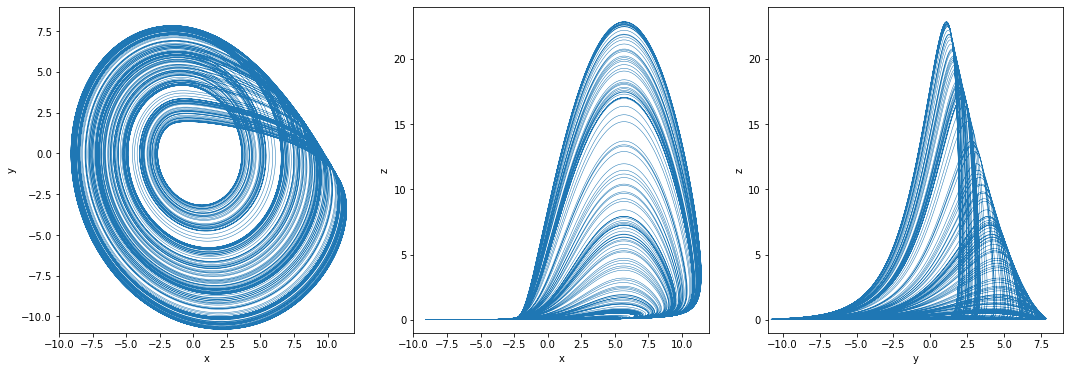

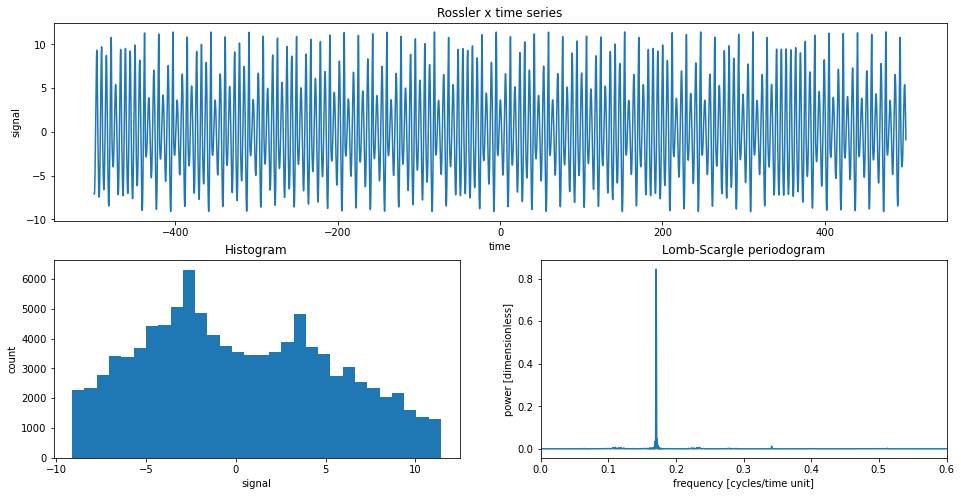

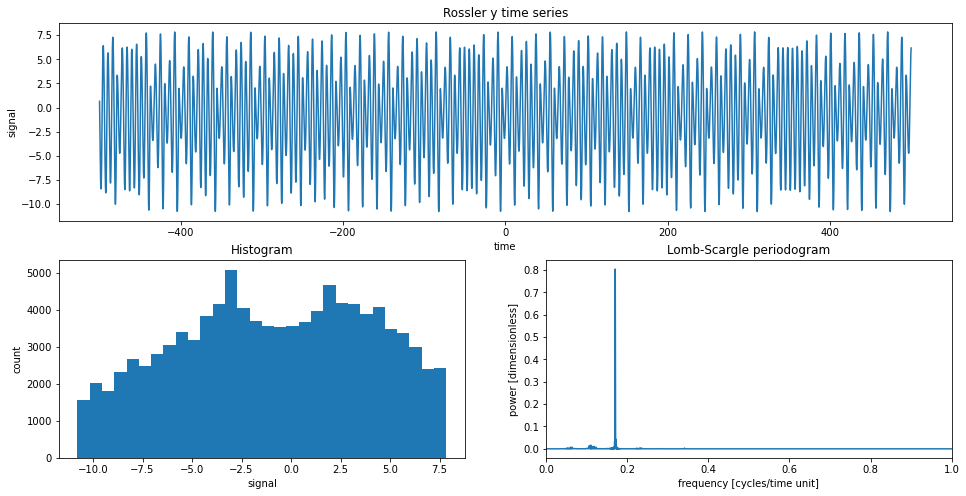

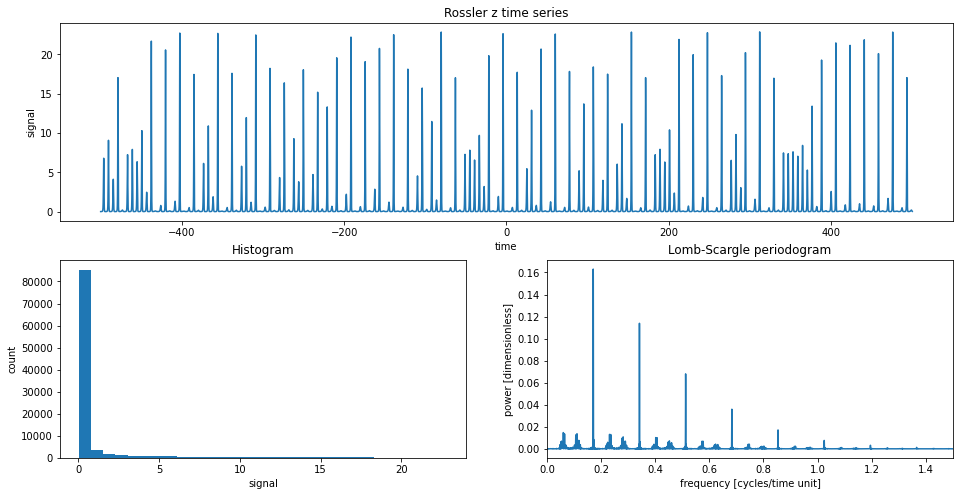

'\nvarnames = [\'x\',\'y\',\'z\']\n\n\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(rossler_t, rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)\n\n            rossler_r_arr = np.atleast_2d(r0)\n            rossler_t_arr = np.array((tmin))\n\n            while rossler.t < tmax:\n                rossler.step()

In [29]:
#r0 = np.array((1.,1.,1.))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-7.06916283,  0.71266172,  0.01578853))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-10,12)
axes[0].set_ylim(-11,9)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-10,12)
axes[1].set_ylim(-1,24)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-11,9)
axes[2].set_ylim(-1,24)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
sp.plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
sp.plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

"""
varnames = ['x','y','z']


#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(rossler_t, rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)

            rossler_r_arr = np.atleast_2d(r0)
            rossler_t_arr = np.array((tmin))

            while rossler.t < tmax:
                rossler.step()
                rossler_r_arr = np.vstack((rossler_r_arr, rossler.y))
                rossler_t_arr = np.vstack((rossler_t_arr, rossler.t))

            rossler_t_arr = rossler_t_arr[0:Nsteps]
            rossler_r_arr = rossler_r_arr[0:Nsteps]
            
            #print(np.shape(rossler_t_arr))
            #print(np.shape(rossler_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(rossler_t_arr, rossler_r_arr[:,i], 'k.',ms=2)
            ax.plot(rossler_t_arr[::2],rossler_r_arr[::2,i],'r.',ms=5)
            ax.plot(rossler_t_arr[::10],rossler_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[:,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr)
        
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[::5,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr[::5])
              
            #np.save("./corrDimTesting/rossler/rossler_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_r_arr[::10,i])
            #np.save("./corrDimTesting/rossler/rossler_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),rossler_t_arr[::10])
            
            for throwawaystep in range(10000):
                rossler.step()
                
            r0 = rossler.y
"""

In [30]:
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],'k-',lw=2)
#ax.axis("off")
#plt.savefig("./rossler_x_forposter.pdf")

ax.axvline(362.35)
ax.axvline(368.35)
plt.show()

print((368.35-362.35)/0.01)
plt.show()
"""

'\nfig, ax = plt.subplots(1,1,figsize=(16,6))\nax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],\'k-\',lw=2)\n#ax.axis("off")\n#plt.savefig("./rossler_x_forposter.pdf")\n\nax.axvline(362.35)\nax.axvline(368.35)\nplt.show()\n\nprint((368.35-362.35)/0.01)\nplt.show()\n'

### transformed Rossler system (inspired by Letellier & Aguirre 2002)

[-4.11794787  7.35916455  2.52762002]


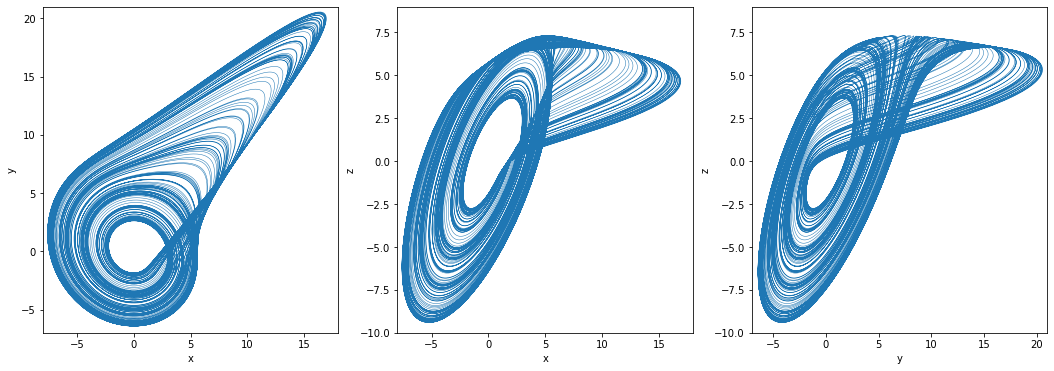

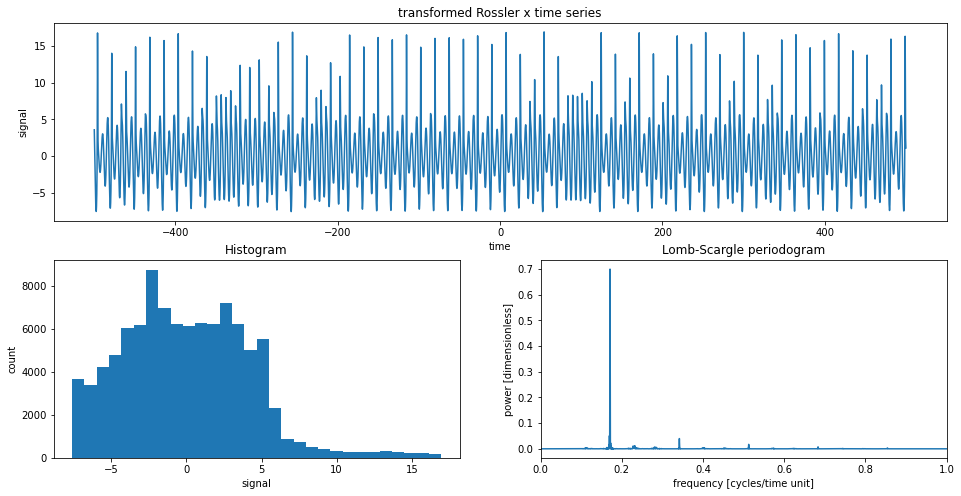

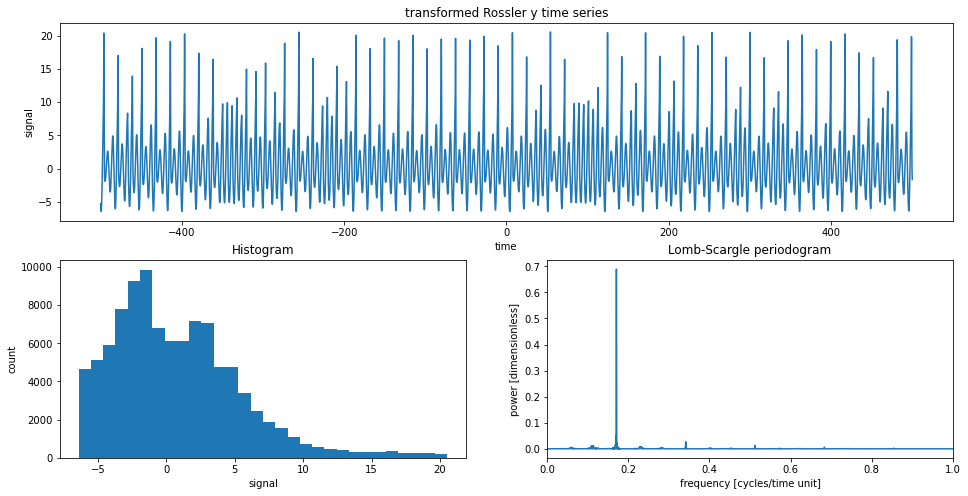

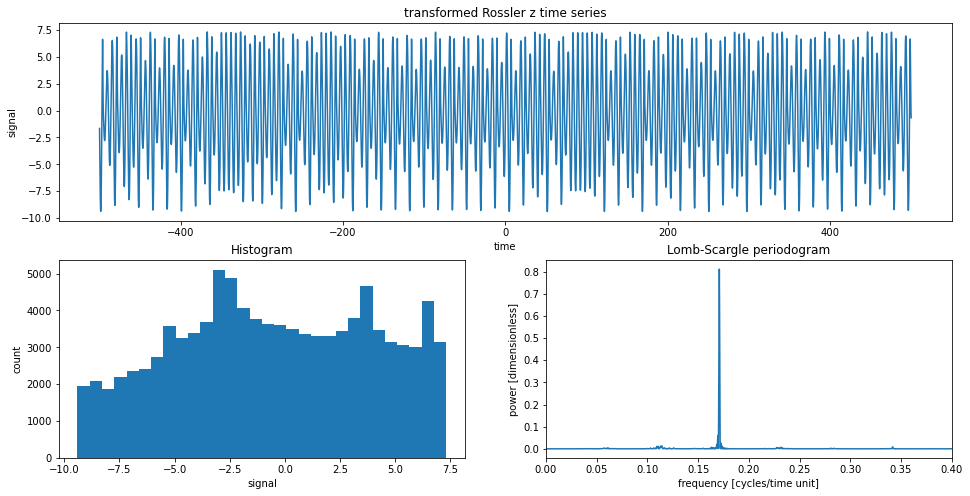

'\nvarnames = [\'x\',\'y\',\'z\']\n\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(transformed_rossler_t, transformed_rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)\n\n            transformed_rossler_r_arr = np.atleast_2d(r0)\n            transformed_rossler_t_arr = np.array((tmin))\

In [31]:
rossler_fp1 = np.array((0.0070262, -0.03513102, 0.03513102)) # central. strongly attractive in z, repulsive spiral in x, y
rossler_fp2 = np.array((5.6929738, -28.46486898, 28.46486898)) # outlying. repulsive in z, weak attractive spiral in x,y

transformed_rossler_fp1 = (1./np.sqrt(2))*np.array((rossler_fp1[1] + rossler_fp1[2], rossler_fp1[2] + rossler_fp1[0], rossler_fp1[0] + rossler_fp1[1]))
transformed_rossler_fp2 = (1./np.sqrt(2))*np.array((rossler_fp2[1] + rossler_fp2[2], rossler_fp2[2] + rossler_fp2[0], rossler_fp2[0] + rossler_fp2[1]))


#r0 = (1.,1.,1.)
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((3.6162099,  -5.17683558, -1.58314013))

# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

transformed_rossler_r = np.empty((Nsteps,3))
transformed_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    transformed_rossler.step()
    transformed_rossler_t[i] = transformed_rossler.t
    transformed_rossler_r[i] = transformed_rossler.y
    #print(i, transformed_rossler_r[i])
print(transformed_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(transformed_rossler_r[:,0],transformed_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,18)
axes[0].set_ylim(-7,21)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(transformed_rossler_r[:,0],transformed_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,18)
axes[1].set_ylim(-10,9)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(transformed_rossler_r[:,1],transformed_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-7,21)
axes[2].set_ylim(-10,9)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(transformed_rossler_t,transformed_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="transformed Rossler x")
sp.plotTimeSeries(transformed_rossler_t,transformed_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="transformed Rossler y")
sp.plotTimeSeries(transformed_rossler_t,transformed_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="transformed Rossler z")
"""
varnames = ['x','y','z']

#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(transformed_rossler_t, transformed_rossler_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)

            transformed_rossler_r_arr = np.atleast_2d(r0)
            transformed_rossler_t_arr = np.array((tmin))

            while transformed_rossler.t < tmax:
                transformed_rossler.step()
                transformed_rossler_r_arr = np.vstack((transformed_rossler_r_arr, transformed_rossler.y))
                transformed_rossler_t_arr = np.vstack((transformed_rossler_t_arr, transformed_rossler.t))

            transformed_rossler_t_arr = transformed_rossler_t_arr[0:Nsteps]
            transformed_rossler_r_arr = transformed_rossler_r_arr[0:Nsteps]
            
            #print(np.shape(transformed_rossler_t_arr))
            #print(np.shape(transformed_rossler_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(transformed_rossler_t_arr, transformed_rossler_r_arr[:,i], 'k.',ms=2)
            ax.plot(transformed_rossler_t_arr[::2],transformed_rossler_r_arr[::2,i],'r.',ms=5)
            ax.plot(transformed_rossler_t_arr[::10],transformed_rossler_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_r_arr[:,i])
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_t_arr)
            
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_r_arr[::5,i])
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_t_arr[::5])
              
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_r_arr[::10,i])
            #np.save("./corrDimTesting/transformed_rossler/transformed_rossler_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),transformed_rossler_t_arr[::10])
            
            for throwawaystep in range(10000):
                transformed_rossler.step()
            
            r0 = transformed_rossler.y
"""

### Lorenz system

In [32]:
fp1, fp2 = sp.Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


[-0.19799305  1.54182522 22.0096192 ]


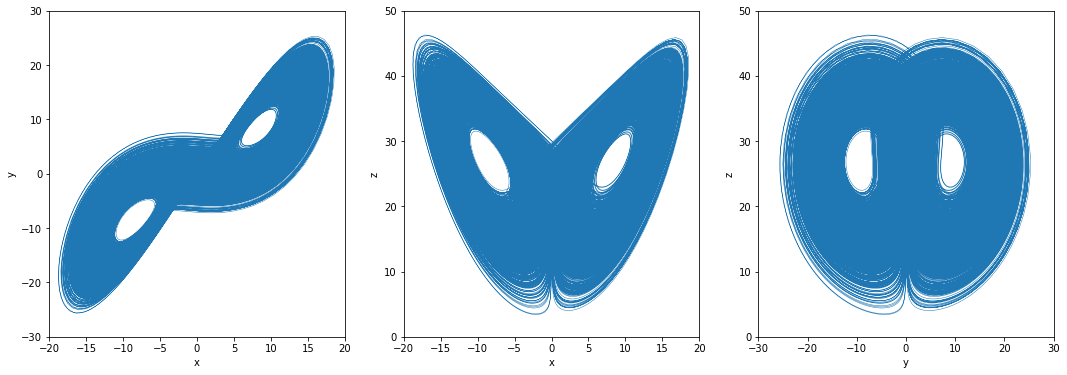

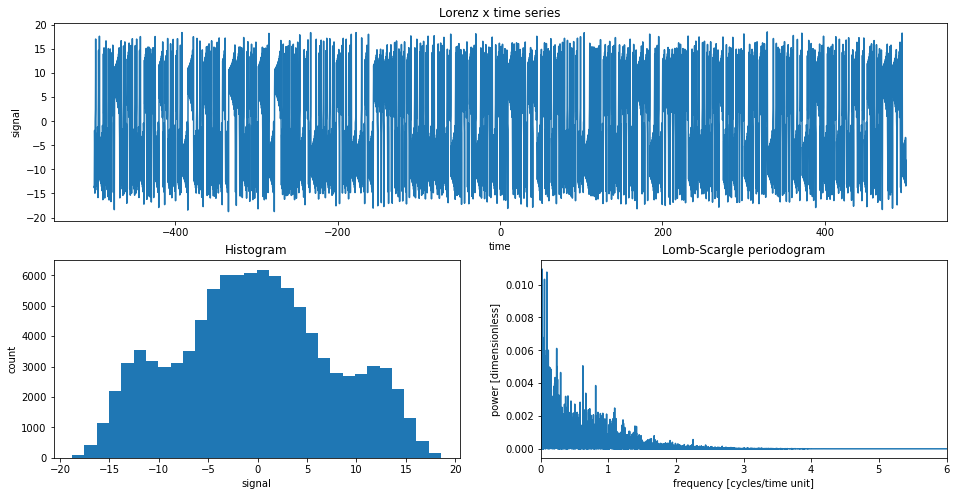

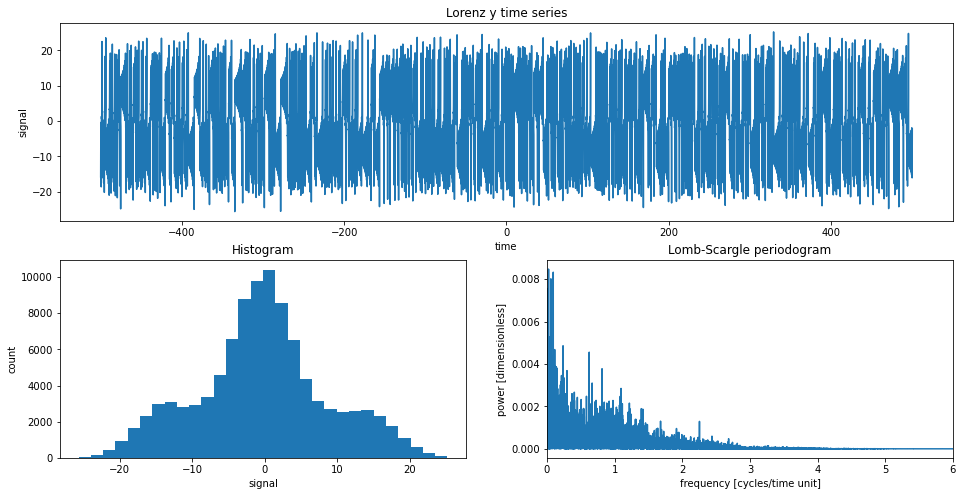

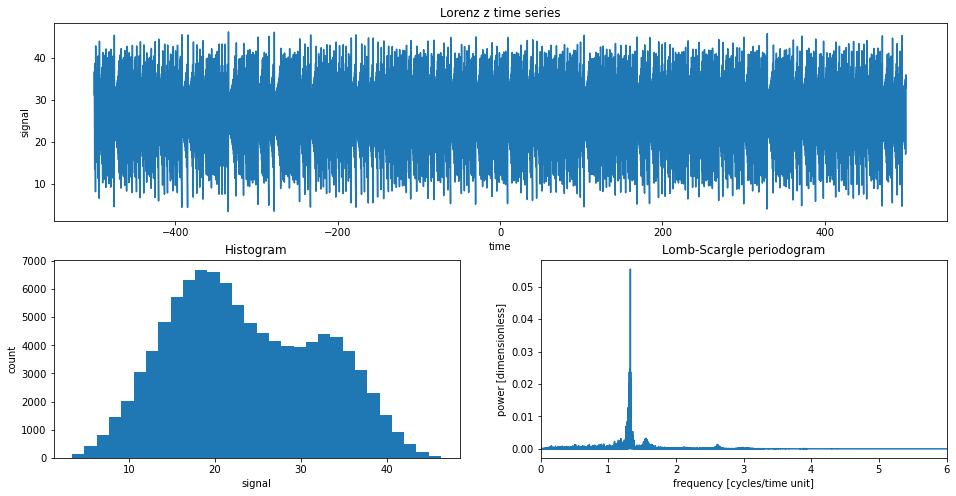

'\nvarnames=[\'x\',\'y\',\'z\']\n\n#now, for x, y, and z: each cadence, each Ncyc, 3 versions.\nfor i in range(3):\n#for i in range(1):\n    qp = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,i], plot=True) # in units of test cadence, dt = 0.01\n    qp_t = qp * dt\n    print(qp_t)\n\n    for N in Ncyc:\n        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator\n        # will choose shorter cadences than I give it in order to maintain accuracy.\n        \n        cad = 0.01 * qp_t\n        Nsteps = int(np.ceil((qp_t * N)/cad))\n        print(Nsteps)\n        \n        for v in range(3):\n            tmin = (qp_t * N)*(v)\n            tmax = (qp_t * N)*(v+1)\n\n            lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)\n\n            lorenz_r_arr = np.atleast_2d(r0)\n            lorenz_t_arr = np.array((tmin))\n\n            while lorenz.t < tmax:\n                lorenz.step()\n          

In [33]:
#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y

print(lorenz_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")
"""
varnames=['x','y','z']

#now, for x, y, and z: each cadence, each Ncyc, 3 versions.
for i in range(3):
#for i in range(1):
    qp = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,i], plot=True) # in units of test cadence, dt = 0.01
    qp_t = qp * dt
    print(qp_t)

    for N in Ncyc:
        # only run the integrator for the shortest cadence, then downsample the results to get longer "cadences." the integrator
        # will choose shorter cadences than I give it in order to maintain accuracy.
        
        cad = 0.01 * qp_t
        Nsteps = int(np.ceil((qp_t * N)/cad))
        print(Nsteps)
        
        for v in range(3):
            tmin = (qp_t * N)*(v)
            tmax = (qp_t * N)*(v+1)

            lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=cad,t_bound=tmax*100)

            lorenz_r_arr = np.atleast_2d(r0)
            lorenz_t_arr = np.array((tmin))

            while lorenz.t < tmax:
                lorenz.step()
                lorenz_r_arr = np.vstack((lorenz_r_arr, lorenz.y))
                lorenz_t_arr = np.vstack((lorenz_t_arr, lorenz.t))

            lorenz_t_arr = lorenz_t_arr[0:Nsteps]
            lorenz_r_arr = lorenz_r_arr[0:Nsteps]
            
            #print(np.shape(lorenz_t_arr))
            #print(np.shape(lorenz_r_arr))

            fig, ax = plt.subplots(1,1,figsize=(10,4))
            ax.plot(lorenz_t_arr, lorenz_r_arr[:,i], 'k.',ms=2)
            ax.plot(lorenz_t_arr[::2],lorenz_r_arr[::2,i],'r.',ms=5)
            ax.plot(lorenz_t_arr[::10],lorenz_r_arr[::10,i],'y.',ms=15)
            plt.show()
            
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[:,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.01_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr)
            
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[::5,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.05_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr[::5])
              
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_r_arr[::10,i])
            #np.save("./corrDimTesting/lorenz/lorenz_{0}_t_Pq={1}_cad=0.1_Ncyc={2}_v{3}.npy".format(varnames[i],np.around(qp_t,1),N,v),lorenz_t_arr[::10])
            
            for throwawaystep in range(10000):
                lorenz.step()
            
            r0 = lorenz.y
"""

In [13]:
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t[-1000:],lorenz_r[-1000:,2],'k-',lw=2)
ax.axis("off")
plt.savefig("./lorenz_z_forposter.pdf")
#plt.show()
"""

'\nfig, ax = plt.subplots(1,1,figsize=(16,6))\nax.plot(lorenz_t[-1000:],lorenz_r[-1000:,2],\'k-\',lw=2)\nax.axis("off")\nplt.savefig("./lorenz_z_forposter.pdf")\n#plt.show()\n'

### testing a way to estimate the cycle period, based on measuring the median interval between successive local extrema, then refining based on local max of mutual info

In [23]:
"""
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,2],plot=True)
print(qp)

qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,2],plot=True)
print(qp)

qp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,0],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,1],plot=True)
print(qp)
qp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,2],plot=True)
print(qp)
"""

'\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=lorenz_t[:],timeSeries=lorenz_r[:,2],plot=True)\nprint(qp)\n\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,2],plot=True)\nprint(qp)\n\nqp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,0],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,1],plot=True)\nprint(qp)\nqp = sp.estimateQuasiPeriod(time=transformed_rossler_t[:],timeSeries=transformed_rossler_r[:,2],plot=True)\nprint(qp)\n'

156
313
470
627


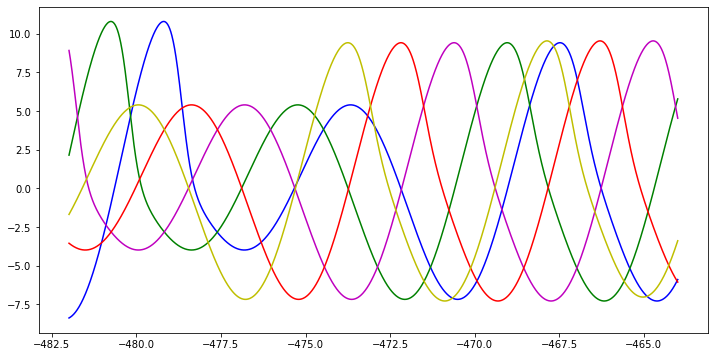

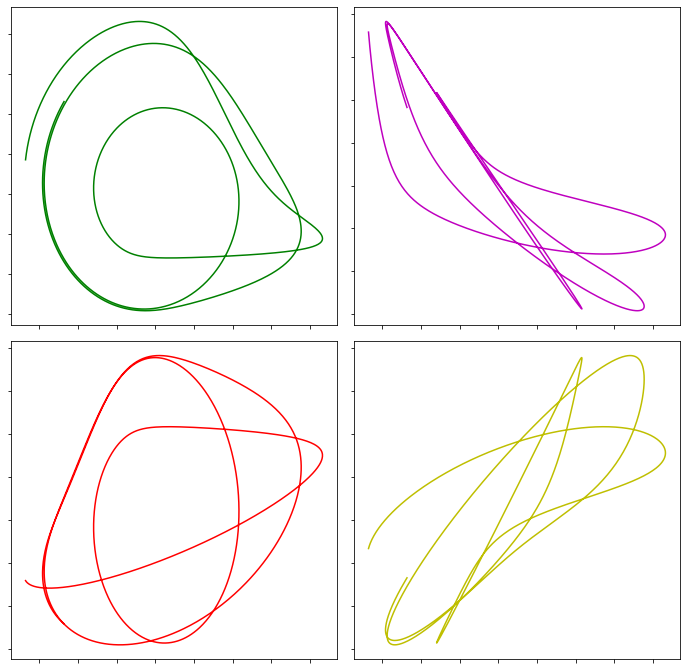

In [24]:
rossler_qp  = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=False)
print(int(rossler_qp/4.))
print(int(rossler_qp/2.))
print(int((3*rossler_qp/4.)))
print(rossler_qp)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(rossler_t[1800:3600],rossler_r[1800:3600,0],color='b')
ax.plot(rossler_t[1800:3600],rossler_r[1800+156:3600+156,0],color='g') # +1/4 quasi-period = 1st local min of MI, 1st zero of autocorr. fn
ax.plot(rossler_t[1800:3600],rossler_r[1800+313:3600+313,0],color='m') # +1/2 quasi-period = 1st local max of MI, autocorr fn = -1
ax.plot(rossler_t[1800:3600],rossler_r[1800+470:3600+470,0],color='r') # +3/4 quasi-period = 2nd local min of MI, 2nd zero of autocorr. fn
ax.plot(rossler_t[1800:3600],rossler_r[1800+627:3600+627,0],color='y') #   +1 quasi-period = 2nd local max of MI, autocorr fn = +1
plt.show()

fig, axes = plt.subplots(2,2,figsize=(12,12))
#axes[0].plot(rossler_r[0:3600,0],rossler_r[0:3600,0],'b')
axes[0,0].plot(rossler_r[1800:3600,0],rossler_r[1800+156:3600+156,0],'g')
axes[0,1].plot(rossler_r[1800:3600,0],rossler_r[1800+313:3600+313,0],'m')
axes[1,0].plot(rossler_r[1800:3600,0],rossler_r[1800+470:3600+470,0],'r')
axes[1,1].plot(rossler_r[1800:3600,0],rossler_r[1800+627:3600+627,0],'y')
for ax in np.ravel(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

In [ ]:
# first or second minimum = first or negative first! positive or negative delay time.

# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

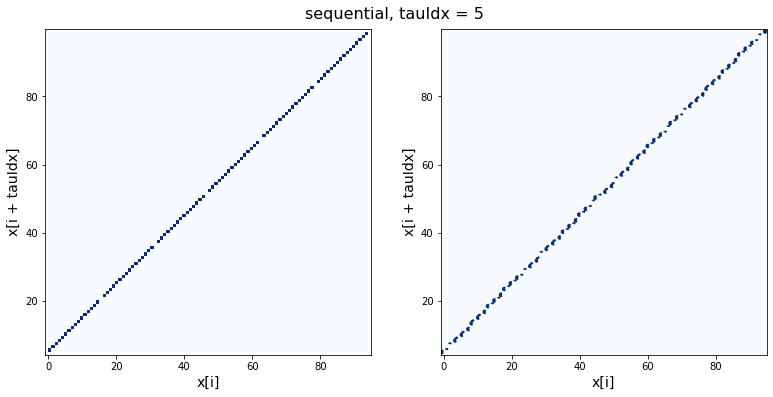

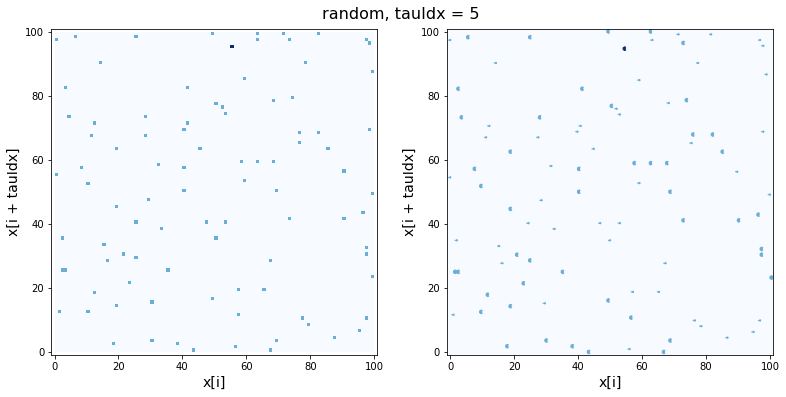

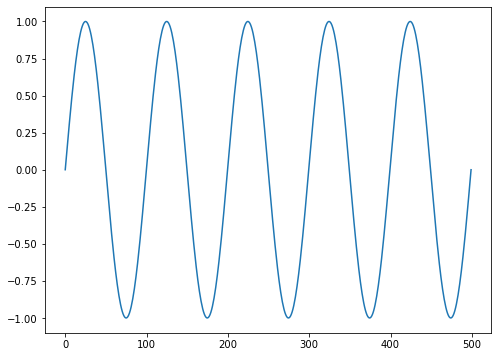

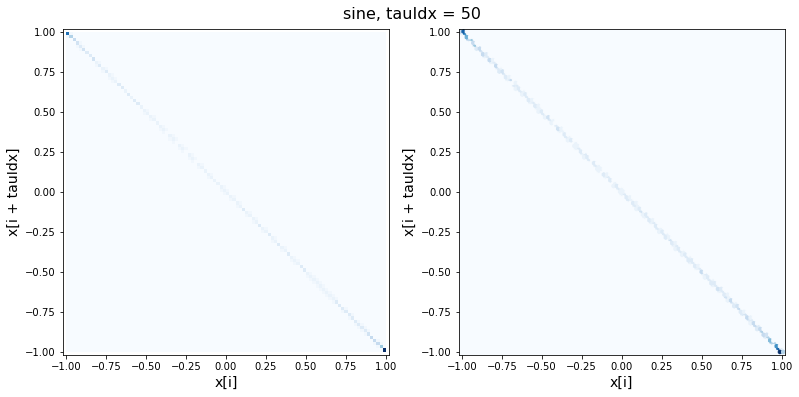

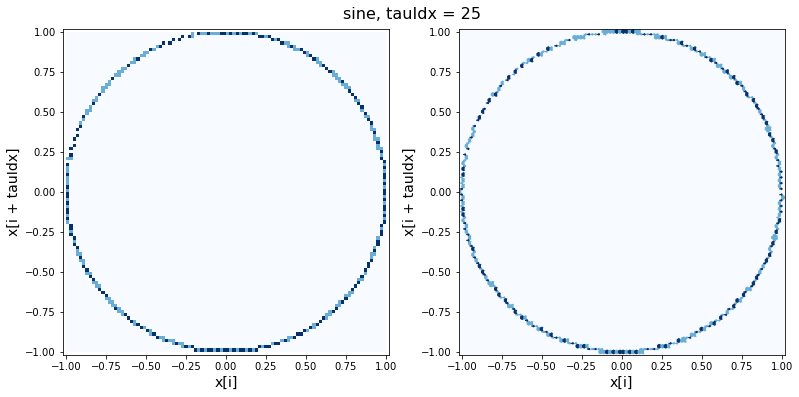

In [ ]:
# test cases:
# sequential array
sp.bin2D(timeSeries=np.arange(100),tauIdx=5,plotTitle="sequential, tauIdx = 5")
# random array
sp.bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5,plotTitle="random, tauIdx = 5")
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(corr_arr)
plt.show()
sp.bin2D(timeSeries=corr_arr, tauIdx = 50, plotTitle="sine, tauIdx = 50") # non-optimal! 
sp.bin2D(timeSeries=corr_arr, tauIdx = 25, plotTitle="sine, tauIdx = 25") # optimal! 50*n = perfect linear correlation

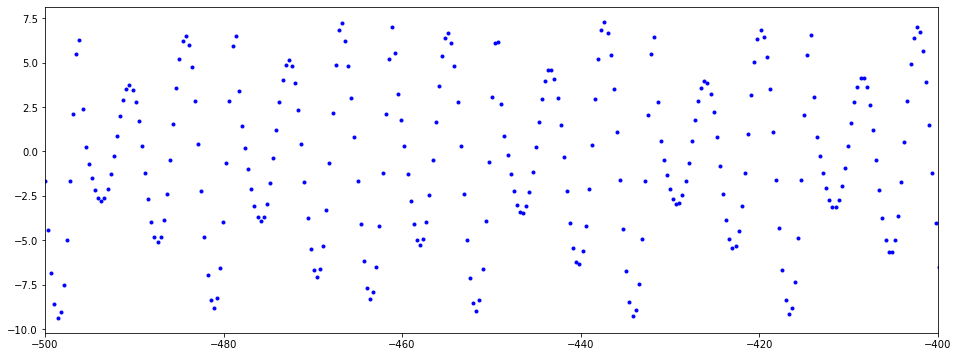

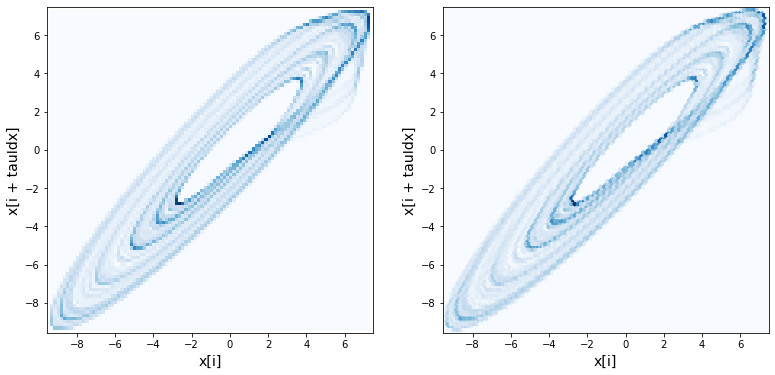

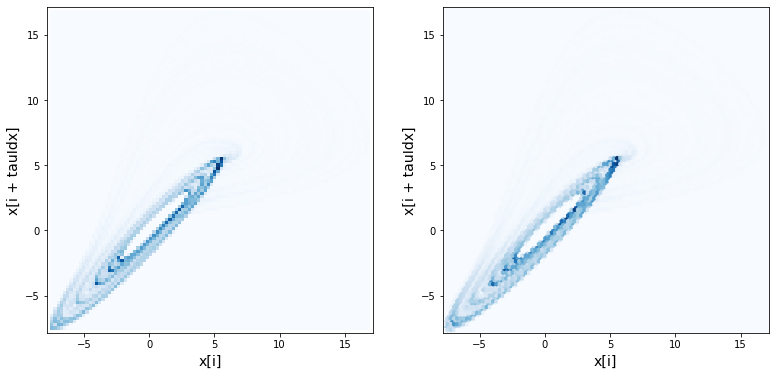

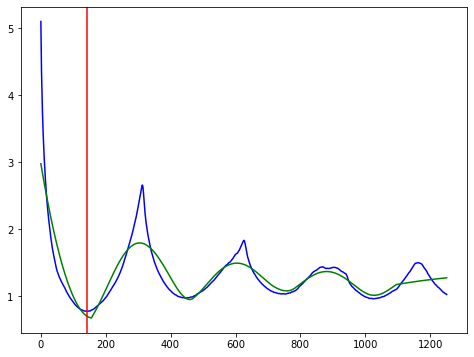

(array([5.10374556, 4.6615529 , 4.34881942, ..., 1.03670591, 1.03529003,
        1.030331  ]),
 143)

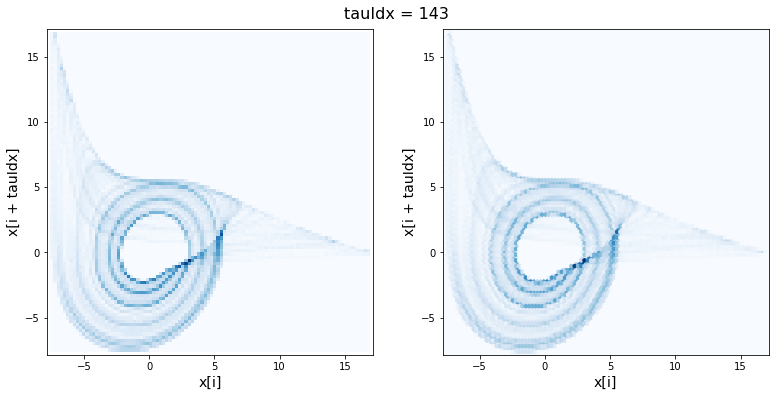

In [25]:
# rossler
#testDelayIdxs = np.array((1,20,50,75,100,109,200,400,500,750,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 35
ax.plot(transformed_rossler_t[::delay],transformed_rossler_r[::delay,2,],'b.')
ax.set_xlim(-500,-400)
plt.show()

sp.bin2D(timeSeries=transformed_rossler_r[:,2], tauIdx = 35) 


sp.bin2D(timeSeries=transformed_rossler_r[:,0], tauIdx = 30)

sp.FS86(time = transformed_rossler_t, timeSeries=transformed_rossler_r[:,0], plot=True)

In [ ]:
testDelayIdxs = np.array((15,20,30,40,50,60,70,80,90))

#fp1 = np.array((8.48528137, 8.48528137, 8.48528137))
#fp2 = np.array((-8.48528137, -8.48528137, -8.48528137))
fp1 = np.array((27.,27.,27.))
fp2 = np.array((27.,27.,27.))
delayMat = sp.delayMatrix(lorenz_r[:,2],tau=15,m=3)

fp1_dist = np.linalg.norm(delayMat - fp1, axis = 1)
fp2_dist = np.linalg.norm(delayMat - fp2, axis = 1)

fp_dist = np.minimum(fp1_dist,fp2_dist)

fig, axes = plt.subplots(6,6,figsize=(20,20))

for i, t in enumerate(testDelayIdxs):
    #sp.bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tauIdx = {0}".format(i))
    delayMat = sp.delayMatrix(lorenz_r[:,2],tau=t,m=3)
    
    x = delayMat[:,0]
    y = delayMat[:,1]
    z = delayMat[:,2]
    
    ai = i//3
    aj = i%3
    
    axes[ai*2,aj*2].plot(x,z,ls='-',lw=0.25,marker='None',zorder=1)
    axes[ai*2,aj*2].scatter(x,z,c=fp_dist[0:len(x)],cmap='magma_r',s=1,zorder=2)
    #axes[ai*2,aj*2].plot(8.4853,8.4853,'k.')
    #axes[ai*2,aj*2].plot(-8.4853,-8.4853,'k.')
    axes[ai*2,aj*2].plot(27.,27.,'k.')
    axes[ai*2,aj*2].set_xlabel("z 'x'")
    axes[ai*2,aj*2].set_ylabel("z 'z'")
    
    axes[ai*2+1,aj*2].plot(x,y,ls='-',lw=0.25,marker='None',zorder=1)
    axes[ai*2+1,aj*2].scatter(x,y,c=fp_dist[0:len(x)],cmap='magma_r',s=1,zorder=2)
    #axes[ai*2+1,aj*2].plot(8.4853,8.4853,'k.')
    #axes[ai*2+1,aj*2].plot(-8.4853,-8.4853,'k.')
    axes[ai*2+1,aj*2].plot(27.,27.,'k.')
    axes[ai*2+1,aj*2].set_xlabel("z 'x'")
    axes[ai*2+1,aj*2].set_ylabel("z 'y'")
    
    axes[ai*2+1,aj*2+1].plot(y,z,ls='-',lw=0.25,marker='None',zorder=1)
    axes[ai*2+1,aj*2+1].scatter(y,z,c=fp_dist[0:len(x)],cmap='magma_r',s=1,zorder=2)
    #axes[ai*2+1,aj*2+1].plot(8.4853,8.4853,'k.')
    #axes[ai*2+1,aj*2+1].plot(-8.4853,-8.4853,'k.')
    axes[ai*2+1,aj*2+1].plot(27.,27.,'k.')
    axes[ai*2+1,aj*2+1].set_xlabel("z 'y'")
    axes[ai*2+1,aj*2+1].set_ylabel("z 'z'")
    
    axes[ai*2,aj*2+1].axis("off")
    
    
    #axes[ai,aj].plot(x,y,ls='-',lw=0.25,marker='None',zorder=1)
    #axes[ai,aj].plot(8.4853,8.4853,'k.')
    #axes[ai,aj].plot(-8.4853,-8.4853,'k.')
    #axes[ai,aj].plot(27,27,'k.')
    #axes[ai,aj].scatter(x,y,c=fp_dist[0:len(x)],cmap='magma_r',s=1,zorder=2)
    #axes[ai,aj].set_title(r"$\tau={0}$".format(t))
    #axes[ai,aj].set_xlim(0,50)
    #axes[ai,aj].set_ylim(0,50)
    
axes[0,5].text(0,0,"Lorenz z",fontsize=20)
plt.subplots_adjust(wspace=0.25,hspace=0.25)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz/lorenz_z_m=3_tau_deformation.png",dpi=300)


#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x 
# time series.

In [ ]:
testDelayIdxs = np.array((15,20,30,40,50,60,70,80,90))

#fp1 = np.array((8.48528137, 8.48528137, 8.48528137))
#fp2 = np.array((-8.48528137, -8.48528137, -8.48528137))
fp1 = np.array((27.,27.,27.))
fp2 = np.array((27.,27.,27.))
delayMat = sp.delayMatrix(lorenz_r[:,2],tau=15,m=3)

fp1_dist = np.linalg.norm(delayMat - fp1, axis = 1)
fp2_dist = np.linalg.norm(delayMat - fp2, axis = 1)

fp_dist = np.minimum(fp1_dist,fp2_dist)

#fig, axes = plt.subplots(3,3,projection='3d',figsize=(20,20))
fig =  plt.figure(figsize=(20,20))

for i, t in enumerate(testDelayIdxs):
    delayMat = sp.delayMatrix(lorenz_r[:,2],tau=t,m=3)
    
    x = delayMat[:,0]
    y = delayMat[:,1]
    z = delayMat[:,2]
    
    ai = i//3
    aj = i%3
    
    ax = fig.add_subplot(3,3,i+1,projection='3d')
    ax.plot3D(x,y,z,color='k',lw=0.1,alpha=1)
    ax.scatter3D(x,y,z,c=fp_dist[0:len(x)],s=1,cmap='magma_r',alpha=0.1)
    ax.set_xlabel("z 'x'")
    ax.set_ylabel("z 'y'")
    ax.set_zlabel("z 'z'")
    ax.set_title(r"$\tau={0}$".format(t))
    
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz/lorenz_z_m=3_tau_deformation_3D.png",dpi=300)


In [69]:
qp_x = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,0], plot=False) # in units of test cadence, dt = 0.01
#print(qp_x) #75

qp_y = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,1], plot=False) # in units of test cadence, dt = 0.01
#print(qp_y) #73

qp_z = sp.estimateQuasiPeriod(lorenz_t, lorenz_r[:,2], plot=False) # in units of test cadence, dt = 0.01
#print(qp_z) #75

qp = int( (qp_x + qp_y + qp_z)/3. ) # in units of test cadence.
print(qp)

length = 400 * qp

MI_x, bestTau_x = sp.FS86(lorenz_t, lorenz_r[:length,0], plot=False) #60
MI_y, bestTau_y = sp.FS86(lorenz_t, lorenz_r[:length,1], plot=False) #59
MI_z, bestTau_z = sp.FS86(lorenz_t, lorenz_r[:length,2], plot=False) #59

bestTau = int( (bestTau_x + bestTau_y + bestTau_z)/3. )
print(bestTau)

delayMat_x = sp.delayMatrix(lorenz_r[:length,0],tau=15,m=3)
delayMat_y = sp.delayMatrix(lorenz_r[:length,1],tau=15,m=3)
delayMat_z = sp.delayMatrix(lorenz_r[:length,2],tau=15,m=3)

fp1 = np.array((8.48528137, 8.48528137, 27.))
fp2 = np.array((-8.48528137, -8.48528137, 27.))
               
fp1_dist = np.linalg.norm(lorenz_r[:length] - fp1, axis=1)
fp2_dist = np.linalg.norm(lorenz_r[:length] - fp2, axis=1)
fp_dist = np.minimum(fp1_dist, fp2_dist)

counter = 0

for tau in np.arange(1,75,1):
#for tau in range(15,16,1):
    print(tau)
    delayMat_x = sp.delayMatrix(lorenz_r[:length,0],tau=tau,m=3)
    delayMat_y = sp.delayMatrix(lorenz_r[:length,1],tau=tau,m=3)
    delayMat_z = sp.delayMatrix(lorenz_r[:length,2],tau=tau,m=3)
    
    
    if np.abs(tau - bestTau_x) <=2 or np.abs(tau - bestTau_y) <=2 or np.abs(tau - bestTau_z) <=2:
        numViews = 30
    else:
        numViews = 10
    

    for a in np.arange(counter,counter+numViews,1):
        
        fig = plt.figure(figsize=(15,15))

        ax_true = fig.add_subplot(2,2,1,projection='3d')
        ax_x = fig.add_subplot(2,2,2,projection='3d')
        ax_MI_x = fig.add_axes(rect=(0.91,0.58,0.22,0.2225))
        ax_MI_y = fig.add_axes(rect=(-0.1,0.2025,0.22,0.2225))
        ax_y = fig.add_subplot(2,2,3,projection='3d')
        ax_z = fig.add_subplot(2,2,4,projection='3d')
        ax_MI_z = fig.add_axes(rect=(0.91,0.2025,0.22,0.2225))
        
        true_line = ax_true.plot3D(lorenz_r[:length,0],lorenz_r[:length,1],lorenz_r[:length,2],color='k',lw=0.1,alpha=1)
        true_scatter = ax_true.scatter3D(lorenz_r[:length,0],lorenz_r[:length,1],lorenz_r[:length,2],c=fp_dist, s=1,cmap='magma_r',alpha=0.2)
    
        x_line = ax_x.plot3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],color='k',lw=0.1,alpha=1)
        x_scatter = ax_x.scatter3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],c=fp_dist[0:len(delayMat_x[:,0])],s=1,cmap='magma_r',alpha=0.2)
        y_line = ax_y.plot3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],color='k',lw=0.1,alpha=1)
        y_scatter = ax_y.scatter3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],c=fp_dist[0:len(delayMat_y[:,0])],s=1,cmap='magma_r',alpha=0.2)
        z_line = ax_z.plot3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],color='k',lw=0.1,alpha=1)
        z_scatter = ax_z.scatter3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],c=fp_dist[0:len(delayMat_z[:,0])],s=1,cmap='magma_r',alpha=0.2)
        
        ax_MI_x.plot(np.arange(1,81), MI_x[:80], 'k-')
        ax_MI_x.axvline(bestTau_x, color='k', linestyle=":")
        ax_MI_x.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        x_ticks = np.arange(0,(5*qp_x)/4, qp_x/4)
        ax_MI_x.set_xticks(x_ticks)
        ax_MI_x.set_yticks([])
        ax_MI_x.set_xticklabels(np.around(x_ticks/qp_x, 2))
        ax_MI_x.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_x.set_ylabel(r"MI",fontsize=14)
    
        
        ax_MI_y.plot(np.arange(1,81), MI_y[:80], 'k-')
        ax_MI_y.axvline(bestTau_y, color='k', linestyle=":")
        ax_MI_y.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        y_ticks = np.arange(0,(5*qp_y)/4, qp_y/4)
        ax_MI_y.set_xticks(y_ticks)
        ax_MI_y.set_yticks([])
        ax_MI_y.set_xticklabels(np.around(y_ticks/qp_y, 2))
        ax_MI_y.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_y.set_ylabel(r"MI",fontsize=14)
        
        ax_MI_z.plot(np.arange(1,81), MI_z[:80], 'k-')
        ax_MI_z.axvline(bestTau_z, color='k', linestyle=":")
        ax_MI_z.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        z_ticks = np.arange(0,(5*qp_z)/4, qp_z/4)
        ax_MI_z.set_xticks(z_ticks)
        ax_MI_z.set_yticks([])
        ax_MI_z.set_xticklabels(np.around(z_ticks/qp_z, 2))
        ax_MI_z.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_z.set_ylabel(r"MI",fontsize=14)
        
        ax_true.plot(8.48528137,8.48528137,27.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_true.plot(-8.48528137,-8.48528137,27.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')   
        ax_true.plot(0.,0.,0.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='left')
        
        ax_x.plot(8.48528137,8.48528137,8.48528137,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_x.plot(-8.48528137,-8.48528137,-8.48528137,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_x.plot(0.,0.,0.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='left')
        
        ax_y.plot(8.48528137,8.48528137,8.48528137,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_y.plot(-8.48528137,-8.48528137,-8.48528137,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_y.plot(0.,0.,0.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='left')
        
        ax_z.plot(27.,27.,27.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        ax_z.plot(0.,0.,0.,marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='left')
        
        #print(a)
        for ax in [ax_true, ax_x, ax_y, ax_z]:    
            ax.view_init(elev=10., azim=a%360)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            
            xmin,xmax = ax.get_xlim()
            ymin,ymax = ax.get_ylim()
            zmin,zmax = ax.get_zlim()
            
            ax.plot(np.linspace(xmin,xmax,3),np.zeros(3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.linspace(ymin,ymax,3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.zeros(3),np.linspace(zmin,zmax,3),'k',ls='-',lw=0.5)
            
        plt.rcParams['axes.titley'] = 0.87
        ax_true.set_title("              ""True Lorenz",fontsize=16,loc="left")
        ax_x.set_title("              "r"Reconstructed from x, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_x,2), np.round(bestTau_x/qp_x, 2)),fontsize=16,loc="left")
        ax_y.set_title("              "r"Reconstructed from y, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_y,2), np.round(bestTau_y/qp_y, 2)),fontsize=16,loc="left")
        ax_z.set_title("              "r"Reconstructed from z, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_z,2), np.round(bestTau_z/qp_z, 2)),fontsize=16,loc="left")
        
        plt.subplots_adjust(wspace=0.,hspace=0.)
        plt.savefig("./plots/gp1983implementation/lorenz/tauDeformationGIF/{0}.jpg".format(str(int(a)).zfill(3)),dpi=100,bbox_inches="tight")
        plt.close()
    counter = a+1


74
59
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [70]:
qp_x = 627 #sp.estimateQuasiPeriod(rossler_t, rossler_r[:,0], plot=False) # in units of test cadence, dt = 0.01
#print(qp_x)

qp_y = 629 #sp.estimateQuasiPeriod(rossler_t, rossler_r[:,1], plot=False) # in units of test cadence, dt = 0.01
#print(qp_y)

qp_z = 587 #sp.estimateQuasiPeriod(rossler_t, rossler_r[:,2], plot=False) # in units of test cadence, dt = 0.01
#print(qp_z)

qp = int( (qp_x + qp_y + qp_z)/3. ) # in units of test cadence.
print(qp) #614

length = 200 * qp

MI_x, bestTau_x = sp.FS86(rossler_t, rossler_r[:length,0], plot=False)
#print(bestTau_x)
MI_y, bestTau_y = sp.FS86(rossler_t, rossler_r[:length,1], plot=False)
#print(bestTau_y)
MI_z, bestTau_z = sp.FS86(rossler_t, rossler_r[:length,2], plot=False)
#print(bestTau_z)

bestTau = int( (bestTau_x + bestTau_y + bestTau_z)/3. )
print(bestTau) #159

delayMat_x = sp.delayMatrix(rossler_r[:length,0],tau=135,m=3)
delayMat_y = sp.delayMatrix(rossler_r[:length,1],tau=135,m=3)
delayMat_z = sp.delayMatrix(rossler_r[:length,2],tau=135,m=3)


fp = np.array((0.0070262,  -0.03513102, 0.03513102))

fp_dist = np.linalg.norm(rossler_r[:length] - fp, axis=1)


rossler_fp1 = np.array((0.0070262, -0.03513102, 0.03513102)) # central. strongly attractive in z, repulsive spiral in x, y
rossler_fp2 = np.array((5.6929738, -28.46486898, 28.46486898)) # outlying. repulsive in z, weak attractive spiral in x,y


counter = 0

for tau in np.arange(1,630,10):
    print(tau)
    delayMat_x = sp.delayMatrix(rossler_r[:length,0],tau=tau,m=3)
    delayMat_y = sp.delayMatrix(rossler_r[:length,1],tau=tau,m=3)
    delayMat_z = sp.delayMatrix(rossler_r[:length,2],tau=tau,m=3)
    
    if np.abs(tau - bestTau_x) <=2 or np.abs(tau - bestTau_y) <=2 or np.abs(tau - bestTau_z) <=2:
        numViews = 30
    else:
        numViews = 10
    
    
    for a in np.arange(counter,counter+numViews,1):
        
        fig = plt.figure(figsize=(15,15))

        ax_true = fig.add_subplot(2,2,1,projection='3d')
        ax_x = fig.add_subplot(2,2,2,projection='3d')
        ax_MI_x = fig.add_axes(rect=(0.91,0.58,0.22,0.2225))
        ax_MI_y = fig.add_axes(rect=(-0.1,0.2025,0.22,0.2225))
        ax_y = fig.add_subplot(2,2,3,projection='3d')
        ax_z = fig.add_subplot(2,2,4,projection='3d')
        ax_MI_z = fig.add_axes(rect=(0.91,0.2025,0.22,0.2225))
        
        true_line = ax_true.plot3D(rossler_r[:length,0],rossler_r[:length,1],rossler_r[:length,2],color='k',lw=0.1,alpha=1)
        true_scatter = ax_true.scatter3D(rossler_r[:length,0],rossler_r[:length,1],rossler_r[:length,2],c=fp_dist, s=1,cmap='magma_r',alpha=0.2)
    
        x_line = ax_x.plot3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],color='k',lw=0.1,alpha=1)
        x_scatter = ax_x.scatter3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],c=fp_dist[0:len(delayMat_x[:,0])],s=1,cmap='magma_r',alpha=0.2)
        y_line = ax_y.plot3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],color='k',lw=0.1,alpha=1)
        y_scatter = ax_y.scatter3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],c=fp_dist[0:len(delayMat_y[:,0])],s=1,cmap='magma_r',alpha=0.2)
        z_line = ax_z.plot3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],color='k',lw=0.1,alpha=1)
        z_scatter = ax_z.scatter3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],c=fp_dist[0:len(delayMat_z[:,0])],s=1,cmap='magma_r',alpha=0.2)
        
        ax_MI_x.plot(np.arange(1,651), MI_x[:650], 'k-')
        ax_MI_x.axvline(bestTau_x, color='k', linestyle=":")
        ax_MI_x.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        x_ticks = np.arange(0,(5*qp_x)/4, qp_x/4)
        ax_MI_x.set_xticks(x_ticks)
        ax_MI_x.set_yticks([])
        ax_MI_x.set_xticklabels(np.around(x_ticks/qp_x, 2))
        ax_MI_x.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_x.set_ylabel(r"MI",fontsize=14)
    
        
        ax_MI_y.plot(np.arange(1,651), MI_y[:650], 'k-')
        ax_MI_y.axvline(bestTau_y, color='k', linestyle=":")
        ax_MI_y.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        y_ticks = np.arange(0,(5*qp_y)/4, qp_y/4)
        ax_MI_y.set_xticks(y_ticks)
        ax_MI_y.set_yticks([])
        ax_MI_y.set_xticklabels(np.around(y_ticks/qp_y, 2))
        ax_MI_y.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_y.set_ylabel(r"MI",fontsize=14)
        
        ax_MI_z.plot(np.arange(1,651), MI_z[:650], 'k-')
        ax_MI_z.axvline(bestTau_z, color='k', linestyle=":")
        ax_MI_z.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        z_ticks = np.arange(0,(5*qp_z)/4, qp_z/4)
        ax_MI_z.set_xticks(z_ticks)
        ax_MI_z.set_yticks([])
        ax_MI_z.set_xticklabels(np.around(z_ticks/qp_z, 2))
        ax_MI_z.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_z.set_ylabel(r"MI",fontsize=14)
        
        
        ax_true.plot(rossler_fp1[0],rossler_fp1[1],rossler_fp1[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_true.plot(rossler_fp2[0],rossler_fp2[1],rossler_fp2[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')   
        
        ax_x.plot(rossler_fp1[0],rossler_fp1[0],rossler_fp1[0],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_x.plot(rossler_fp2[0],rossler_fp2[0],rossler_fp2[0],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='full')
        
        ax_y.plot(rossler_fp1[1],rossler_fp1[1],rossler_fp1[1],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_y.plot(rossler_fp2[1],rossler_fp2[1],rossler_fp2[1],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='full')
        
        ax_z.plot(rossler_fp1[2],rossler_fp1[2],rossler_fp1[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_z.plot(rossler_fp2[2],rossler_fp2[2],rossler_fp2[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='none')

        
        #print(a)
        for ax in [ax_true, ax_x, ax_y, ax_z]:    
            ax.view_init(elev=10., azim=a%360)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            
            xmin,xmax = ax.get_xlim()
            ymin,ymax = ax.get_ylim()
            zmin,zmax = ax.get_zlim()
            
            ax.plot(np.linspace(xmin,xmax,3),np.zeros(3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.linspace(ymin,ymax,3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.zeros(3),np.linspace(zmin,zmax,3),'k',ls='-',lw=0.5)
        
        plt.rcParams['axes.titley'] = 0.87
        ax_true.set_title("              "r"True Rössler",fontsize=16,loc="left")
        ax_x.set_title("              "r"Reconstructed from x, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_x,2), np.round(bestTau_x/qp_x, 2)),fontsize=16,loc="left")
        ax_y.set_title("              "r"Reconstructed from y, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_y,2), np.round(bestTau_y/qp_y, 2)),fontsize=16,loc="left")
        ax_z.set_title("              "r"Reconstructed from z, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_z,2), np.round(bestTau_z/qp_z, 2)),fontsize=16,loc="left")
        
        plt.subplots_adjust(wspace=0.,hspace=0.)
        plt.savefig("./plots/gp1983implementation/rossler/tauDeformationGIF/{0}.jpg".format(str(int(a)).zfill(3)),dpi=100,bbox_inches="tight")
        plt.close()
    counter = a+1


614
159
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621


In [27]:
qp_x = 626 #sp.estimateQuasiPeriod(transformed_rossler_t, transformed_rossler_r[:,0], plot=False) # in units of test cadence, dt = 0.01
#print(qp_x)

qp_y = 628 #sp.estimateQuasiPeriod(transformed_rossler_t, transformed_rossler_r[:,1], plot=False) # in units of test cadence, dt = 0.01
#print(qp_y)

qp_z = 627 #sp.estimateQuasiPeriod(transformed_rossler_t, transformed_rossler_r[:,2], plot=False) # in units of test cadence, dt = 0.01
#print(qp_z)

qp = int( (qp_x + qp_y + qp_z)/3. ) # in units of test cadence.
print(qp) #627

length = 200 * qp

MI_x, bestTau_x = sp.FS86(transformed_rossler_t, transformed_rossler_r[:length,0], plot=False)
#print(bestTau_x) #146
MI_y, bestTau_y = sp.FS86(transformed_rossler_t, transformed_rossler_r[:length,1], plot=False)
#print(bestTau_y) #156
MI_z, bestTau_z = sp.FS86(transformed_rossler_t, transformed_rossler_r[:length,2], plot=False)
#print(bestTau_z) #157

bestTau = int( (bestTau_x + bestTau_y + bestTau_z)/3. )
print(bestTau) #153

delayMat_x = sp.delayMatrix(transformed_rossler_r[:length,0],tau=146,m=3)
delayMat_y = sp.delayMatrix(transformed_rossler_r[:length,1],tau=146,m=3)
delayMat_z = sp.delayMatrix(transformed_rossler_r[:length,2],tau=146,m=3)


rossler_fp1 = np.array((0.0070262, -0.03513102, 0.03513102)) # central. strongly attractive in z, repulsive spiral in x, y
rossler_fp2 = np.array((5.6929738, -28.46486898, 28.46486898)) # outlying. repulsive in z, weak attractive spiral in x,y

transformed_rossler_fp1 = (1./np.sqrt(2))*np.array((rossler_fp1[1] + rossler_fp1[2], rossler_fp1[2] + rossler_fp1[0], rossler_fp1[0] + rossler_fp1[1]))
transformed_rossler_fp2 = (1./np.sqrt(2))*np.array((rossler_fp2[1] + rossler_fp2[2], rossler_fp2[2] + rossler_fp2[0], rossler_fp2[0] + rossler_fp2[1]))

fp_dist = np.linalg.norm(transformed_rossler_r[:length] - transformed_rossler_fp1, axis=1)


counter = 0


for tau in np.arange(1,630,10):
    print(tau)
    delayMat_x = sp.delayMatrix(transformed_rossler_r[:length,0],tau=tau,m=3)
    delayMat_y = sp.delayMatrix(transformed_rossler_r[:length,1],tau=tau,m=3)
    delayMat_z = sp.delayMatrix(transformed_rossler_r[:length,2],tau=tau,m=3)
    
    if np.abs(tau - bestTau_x) <=2 or np.abs(tau - bestTau_y) <=2 or np.abs(tau - bestTau_z) <=2:
        numViews = 30
    else:
        numViews = 10
    
    
    for a in np.arange(counter,counter+numViews,1):
        
        fig = plt.figure(figsize=(15,15))

        ax_true = fig.add_subplot(2,2,1,projection='3d')
        ax_x = fig.add_subplot(2,2,2,projection='3d')
        ax_MI_x = fig.add_axes(rect=(0.91,0.58,0.22,0.2225))
        ax_MI_y = fig.add_axes(rect=(-0.1,0.2025,0.22,0.2225))
        ax_y = fig.add_subplot(2,2,3,projection='3d')
        ax_z = fig.add_subplot(2,2,4,projection='3d')
        ax_MI_z = fig.add_axes(rect=(0.91,0.2025,0.22,0.2225))
        
        true_line = ax_true.plot3D(transformed_rossler_r[:length,0],transformed_rossler_r[:length,1],transformed_rossler_r[:length,2],color='k',lw=0.1,alpha=1)
        true_scatter = ax_true.scatter3D(transformed_rossler_r[:length,0],transformed_rossler_r[:length,1],transformed_rossler_r[:length,2],c=fp_dist, s=1,cmap='magma_r',alpha=0.2)
    
        x_line = ax_x.plot3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],color='k',lw=0.1,alpha=1)
        x_scatter = ax_x.scatter3D(delayMat_x[:,0],delayMat_x[:,1],delayMat_x[:,2],c=fp_dist[0:len(delayMat_x[:,0])],s=1,cmap='magma_r',alpha=0.2)
        y_line = ax_y.plot3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],color='k',lw=0.1,alpha=1)
        y_scatter = ax_y.scatter3D(delayMat_y[:,0],delayMat_y[:,1],delayMat_y[:,2],c=fp_dist[0:len(delayMat_y[:,0])],s=1,cmap='magma_r',alpha=0.2)
        z_line = ax_z.plot3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],color='k',lw=0.1,alpha=1)
        z_scatter = ax_z.scatter3D(delayMat_z[:,0],delayMat_z[:,1],delayMat_z[:,2],c=fp_dist[0:len(delayMat_z[:,0])],s=1,cmap='magma_r',alpha=0.2)
        
        ax_MI_x.plot(np.arange(1,651), MI_x[:650], 'k-')
        ax_MI_x.axvline(bestTau_x, color='k', linestyle=":")
        ax_MI_x.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        x_ticks = np.arange(0,(5*qp_x)/4, qp_x/4)
        ax_MI_x.set_xticks(x_ticks)
        ax_MI_x.set_yticks([])
        ax_MI_x.set_xticklabels(np.around(x_ticks/qp_x, 2))
        ax_MI_x.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_x.set_ylabel(r"MI",fontsize=14)
    
        
        ax_MI_y.plot(np.arange(1,651), MI_y[:650], 'k-')
        ax_MI_y.axvline(bestTau_y, color='k', linestyle=":")
        ax_MI_y.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        y_ticks = np.arange(0,(5*qp_y)/4, qp_y/4)
        ax_MI_y.set_xticks(y_ticks)
        ax_MI_y.set_yticks([])
        ax_MI_y.set_xticklabels(np.around(y_ticks/qp_y, 2))
        ax_MI_y.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_y.set_ylabel(r"MI",fontsize=14)
        
        ax_MI_z.plot(np.arange(1,651), MI_z[:650], 'k-')
        ax_MI_z.axvline(bestTau_z, color='k', linestyle=":")
        ax_MI_z.axvline(tau, ls="-", color="#f9564f",lw=1.5)
        z_ticks = np.arange(0,(5*qp_z)/4, qp_z/4)
        ax_MI_z.set_xticks(z_ticks)
        ax_MI_z.set_yticks([])
        ax_MI_z.set_xticklabels(np.around(z_ticks/qp_z, 2))
        ax_MI_z.set_xlabel(r"$\tau$ [cycles]",fontsize=14)
        ax_MI_z.set_ylabel(r"MI",fontsize=14)
        
        ax_true.plot(transformed_rossler_fp1[0],transformed_rossler_fp1[1],transformed_rossler_fp1[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_true.plot(transformed_rossler_fp2[0],transformed_rossler_fp2[1],transformed_rossler_fp2[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')   
        
        ax_x.plot(transformed_rossler_fp1[0],transformed_rossler_fp1[0],transformed_rossler_fp1[0],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_x.plot(transformed_rossler_fp2[0],transformed_rossler_fp2[0],transformed_rossler_fp2[0],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='full')
        
        ax_y.plot(transformed_rossler_fp1[1],transformed_rossler_fp1[1],transformed_rossler_fp1[1],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_y.plot(transformed_rossler_fp2[1],transformed_rossler_fp2[1],transformed_rossler_fp2[1],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='full')
        
        ax_z.plot(transformed_rossler_fp1[2],transformed_rossler_fp1[2],transformed_rossler_fp1[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='right')
        #ax_z.plot(transformed_rossler_fp2[2],transformed_rossler_fp2[2],transformed_rossler_fp2[2],marker='o',markersize=8,color='k',markerfacecolor='k',fillstyle='none')

        
        
        #print(a)
        for ax in [ax_true, ax_x, ax_y, ax_z]:    
            ax.view_init(elev=10., azim=a%360)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            
            xmin,xmax = ax.get_xlim()
            ymin,ymax = ax.get_ylim()
            zmin,zmax = ax.get_zlim()
            
            ax.plot(np.linspace(xmin,xmax,3),np.zeros(3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.linspace(ymin,ymax,3),np.zeros(3),'k',ls='-',lw=0.5)
            ax.plot(np.zeros(3),np.zeros(3),np.linspace(zmin,zmax,3),'k',ls='-',lw=0.5)
        
        plt.rcParams['axes.titley'] = 0.87
        ax_true.set_title("              "r"True transformed Rössler",fontsize=16,loc="left")
        ax_x.set_title("              "r"Reconstructed from x, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_x,2), np.round(bestTau_x/qp_x, 2)),fontsize=16,loc="left")
        ax_y.set_title("              "r"Reconstructed from y, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_y,2), np.round(bestTau_y/qp_y, 2)),fontsize=16,loc="left")
        ax_z.set_title("              "r"Reconstructed from z, $\tau={0}$ cycles""\n""              "r"[optimal $\tau={1}$ cycles]".format(np.round(tau/qp_z,2), np.round(bestTau_z/qp_z, 2)),fontsize=16,loc="left")
        
        plt.subplots_adjust(wspace=0.,hspace=0.)
        plt.savefig("./plots/gp1983implementation/transformed_rossler/tauDeformationGIF/{0}.jpg".format(str(int(a)).zfill(3)),dpi=100,bbox_inches="tight")
        plt.close()
    counter = a+1


627
148
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621


In [14]:
MI = np.zeros((500))

start = time.time()
for i in range(500):
    MI[i] = sp.calc_MI(lorenz_r[:-(i+1),0], lorenz_r[(i+1):,0],Xbins=sp.optimal_Nbins(lorenz_r[:-(i+1),0]), Ybins = sp.optimal_Nbins(lorenz_r[(i+1):,0]))
end = time.time()
print((end - start)/500.)

0.018212899684906005


In [16]:
#expectation of first minimum, based on FS86
firstMin = ((193.3*(np.pi/100.)) * 0.23) * 100
print(firstMin)

139.67206778594863


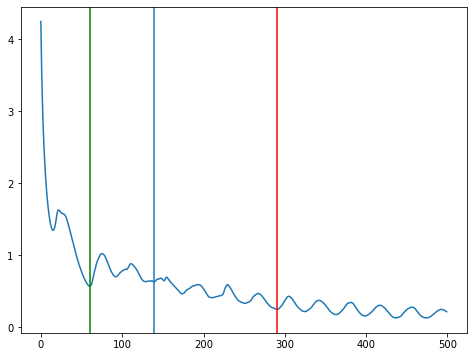

290


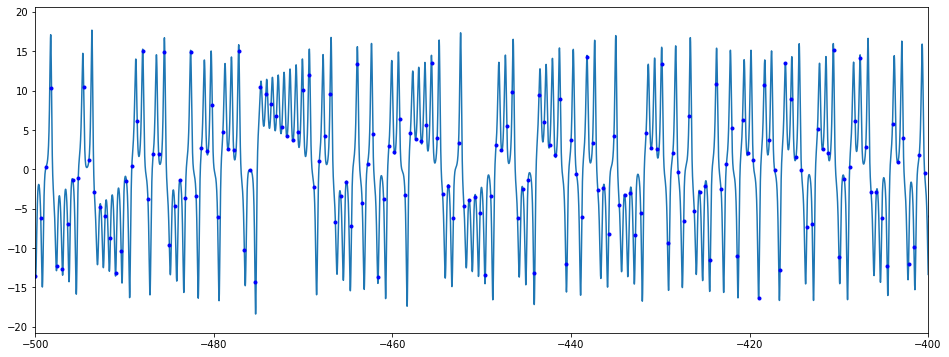

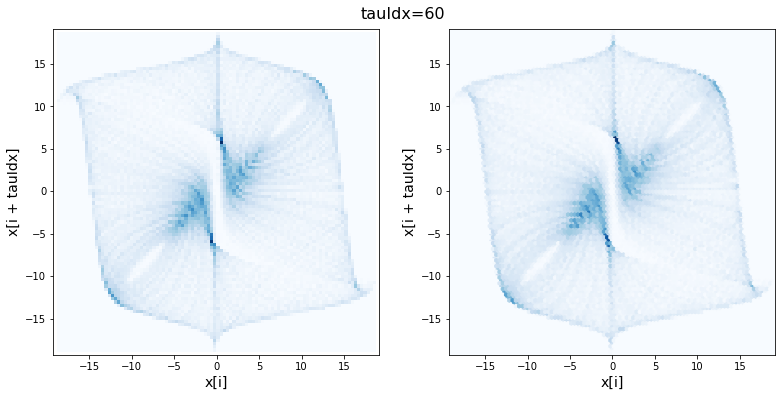

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(MI)
ax.axvline(firstMin)
ax.axvline(np.argmin(MI[0:300]),color='r')
ax.axvline(45+15,color='g')
plt.show()
print(np.argmin(MI[0:300]))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t,lorenz_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 60 #np.argmin(MI[0:300])
ax.plot(lorenz_t[::delay],lorenz_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()
sp.bin2D(timeSeries=lorenz_r[:,0], tauIdx = 60, plotTitle="tauIdx=60")#plotTitle="tauIdx = {0}".format(np.argmin(MI[0:300])))

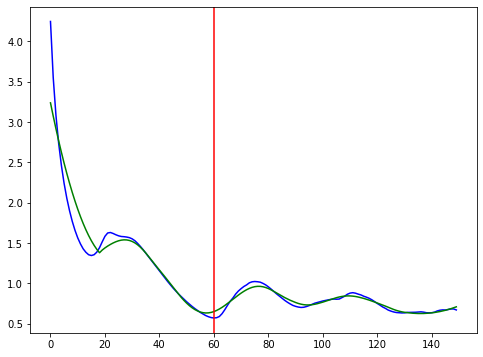

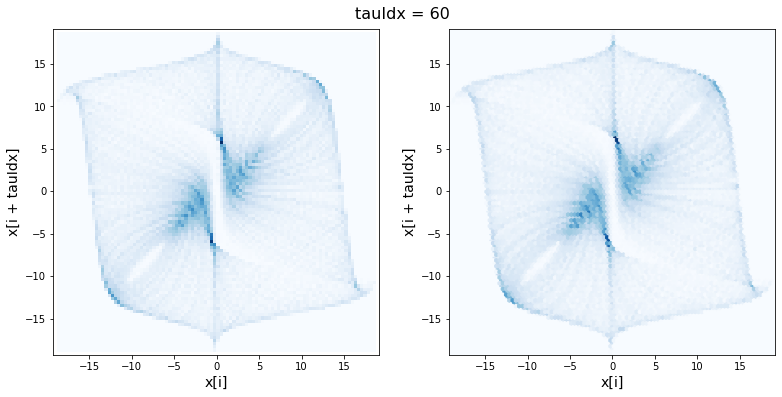

In [15]:
mutInfo, bestTau = sp.FS86(time = lorenz_t, timeSeries = lorenz_r[:,0], plot=True)

# Choose embedding dimension

### Cao 1997

In [16]:
rossler_x_f = ! ls ./corrDimTesting/rossler/rossler_x_P*.npy
rossler_y_f = ! ls ./corrDimTesting/rossler/rossler_y_P*.npy
rossler_z_f = ! ls ./corrDimTesting/rossler/rossler_z_P*.npy
rossler_f = list(rossler_x_f) + list(rossler_y_f) + list(rossler_z_f)

transformed_rossler_x_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_x_P*.npy
transformed_rossler_y_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_y_P*.npy
transformed_rossler_z_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_z_P*.npy
transformed_rossler_f = list(transformed_rossler_x_f) + list(transformed_rossler_y_f) + list(transformed_rossler_z_f)

lorenz_x_f = ! ls ./corrDimTesting/lorenz/lorenz_x_P*.npy
lorenz_y_f = ! ls ./corrDimTesting/lorenz/lorenz_y_P*.npy
lorenz_z_f = ! ls ./corrDimTesting/lorenz/lorenz_z_P*.npy
lorenz_f = list(lorenz_x_f) + list(lorenz_y_f) + list(lorenz_z_f)

print(len(rossler_f))
print(len(transformed_rossler_f))
print(len(lorenz_f))

81
81
81


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

y, Pq=0.7_cad=0.01_Ncyc=5_v1
lorenz_y_Pq=0.7_cad=0.01_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


y, Pq=0.7_cad=0.05_Ncyc=5_v2
lorenz_y_Pq=0.7_cad=0.05_Ncyc=5_v2.npy
something went wrong in FS86! returning global min of MI


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


z, Pq=0.7_cad=0.01_Ncyc=10_v1
lorenz_z_Pq=0.7_cad=0.01_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


z, Pq=0.7_cad=0.05_Ncyc=5_v0
lorenz_z_Pq=0.7_cad=0.05_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

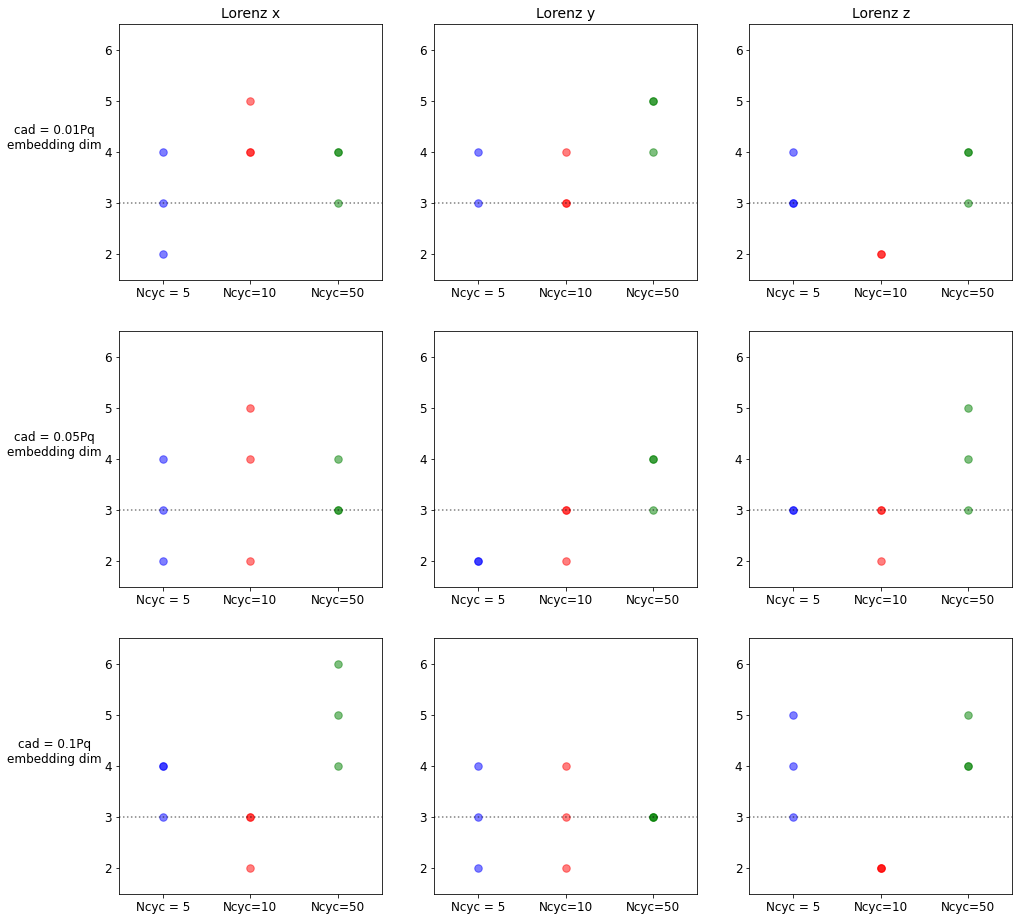

In [23]:

fig, axes = plt.subplots(3,3,figsize=(16,16))

for ts in lorenz_f:
#for ts in ["./corrDimTesting/lorenz_x_Pq=0.8_cad=0.1_Ncyc=5_v0.npy","./corrDimTesting/lorenz_x_Pq=0.8_cad=0.1_Ncyc=5_v1.npy","./corrDimTesting/lorenz_y_Pq=0.7_cad=0.1_Ncyc=10_v0.npy","./corrDimTesting/lorenz_y_Pq=0.7_cad=0.1_Ncyc=10_v1.npy"]:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    #print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "transformed" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=8)
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
    ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
    if sat_m is None:
        print("{0}, {1}".format(varname, details))
    else:
        ax.axvline(sat_m, color='k',linestyle=':')
    ax.set_title("{0}, tau = {1}".format(fileName.split(".npy")[0], bestTau))
    ax.set_xlabel('Dimension')
    ax.set_ylabel('E1 & E2')
    ax.legend(loc='best',fontsize=10)
    #plt.show()
    plt.savefig("./plots/cao1997implementation/lorenz/{0}.png".format(fileName.split(".npy")[0]))
    
    plt.close()
    
    if sat_m is None:
        print(fileName)
        """
        fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
        ax2.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
        ax2.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
        #ax2.axvline(sat_m, color='k',linestyle=':')
        ax2.set_title("{0}, tau = {1}".format(fileName.split(".npy")[0], bestTau))
        ax2.set_xlabel('Dimension')
        ax2.set_ylabel('E1 & E2')
        ax2.legend(loc='best',fontsize=10)
        plt.show()
        """
    
    else:
        if varname=="x":
            firstIdx = 0
        elif varname=="y":
            firstIdx = 1
        elif varname=="z":
            firstIdx = 2

        if cad==0.01:
            zerothIdx = 0
        elif cad==0.05:
            zerothIdx = 1
        elif cad==0.1:
            zerothIdx = 2

        if Ncyc==5:
            xplot = 1
            c = 'b'
        elif Ncyc==10:
            xplot = 2
            c = 'r'
        elif Ncyc==50:
            xplot = 3
            c = 'g'

        axes[zerothIdx, firstIdx].plot(xplot, sat_m, color=c, marker='.',markersize=15,alpha=0.5)

axes[0,0].set_ylabel("cad = 0.01Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)
axes[1,0].set_ylabel("cad = 0.05Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)
axes[2,0].set_ylabel("cad = 0.1Pq\nembedding dim", rotation=0, labelpad=50, fontsize=12)

axes[0,0].set_title("Lorenz x",fontsize=14)
axes[0,1].set_title("Lorenz y",fontsize=14)
axes[0,2].set_title("Lorenz z",fontsize=14)

for ax in np.ravel(axes):
    ax.set_xlim(0.5,3.5)
    ax.axhline(3, color='k',linestyle=":", alpha=0.5)
    
    ax.set_ylim(1.5,6.5)
    ax.set_yticks([2,3,4,5,6])
    ax.set_yticklabels(labels=[2,3,4,5,6],fontsize=12)
    
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Ncyc = 5', 'Ncyc=10', 'Ncyc=50'], fontsize=12)
    #ax.set_ylabel("embedding dim")
    
    
plt.savefig("./plots/cao1997implementation/lorenz_m.pdf")

### Gaussian noise

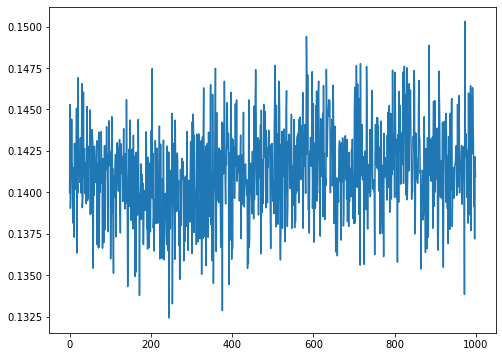

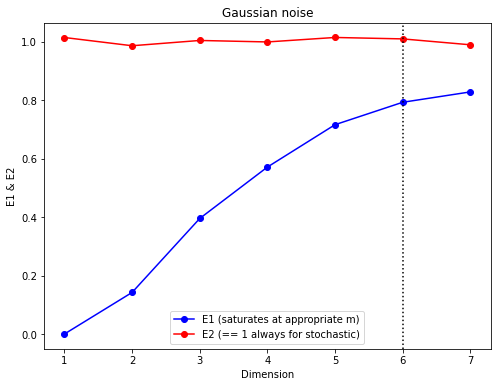

In [37]:
MI = np.zeros(1000)
   
for i,tau in enumerate(np.arange(1000)):
    MI[i] = sp.calc_MI(gaussianNoise[:-(tau+1)], gaussianNoise[(tau+1):],Xbins=sp.optimal_Nbins(gaussianNoise[:-(tau+1)]), Ybins = sp.optimal_Nbins(gaussianNoise[(tau+1):]))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1000), MI)
plt.show()

E1, E2, sat_m = sp.cao97(timeSeries = gaussianNoise[:], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Gaussian noise')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/gaussian_noise.png")

### Simple periodic

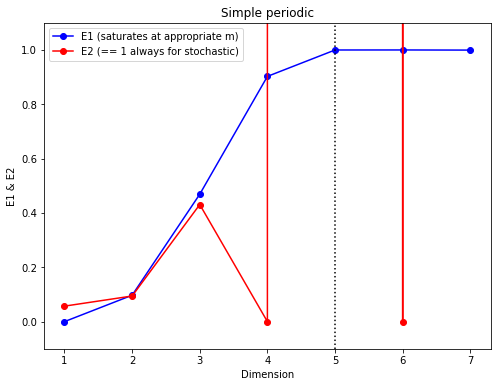

In [38]:
#E1, E2 = sp.cao97(timeSeries = simplePeriodic[:], tau = sp.FS86(time = t, timeSeries = simplePeriodic[:], method="global_min", plot=True)[1], mMax = 8)
E1, E2, sat_m = sp.cao97(timeSeries = simplePeriodic[:], tau = 2060, mMax = 8)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Simple periodic')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.set_ylim(-0.1,1.1)
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/simple_periodic.png")

### Kovacs & Buchler 1988

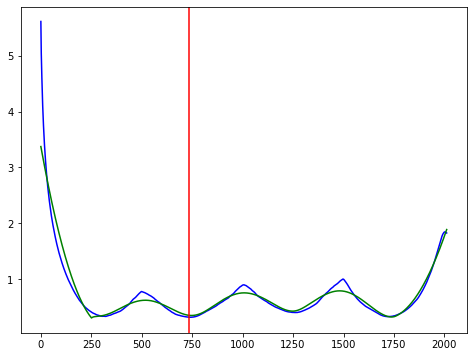

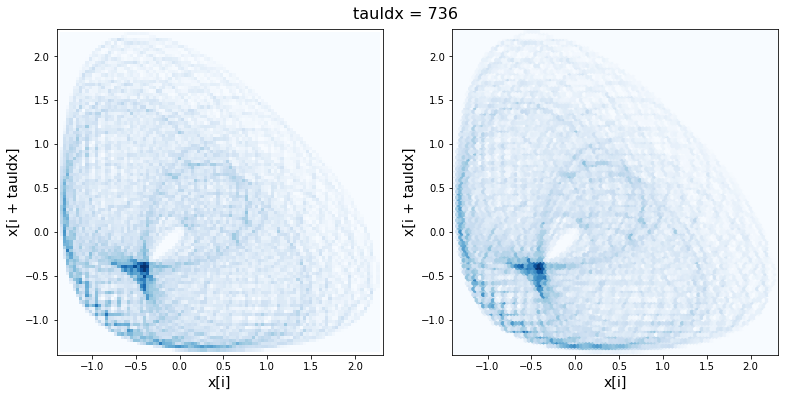

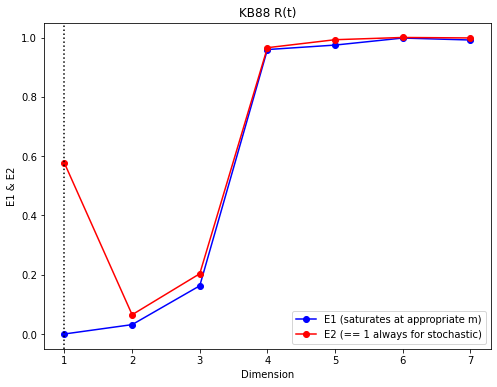

In [39]:
E1, E2, sat_m = sp.cao97(timeSeries = multiPeriodic_r[:], tau = sp.FS86(time=t, timeSeries = multiPeriodic_r[:], plot=True)[1], mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('KB88 R(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_r.png")

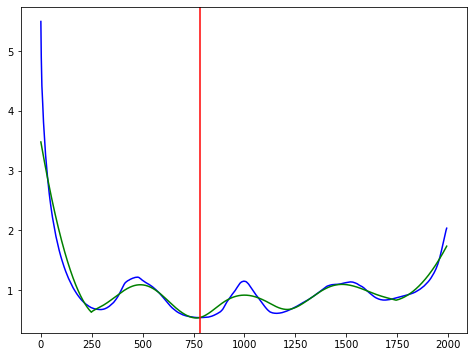

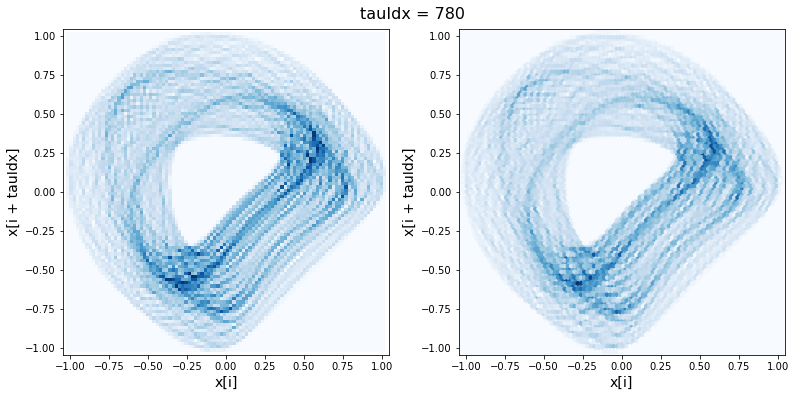

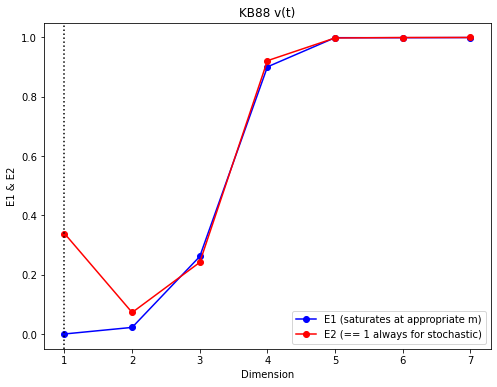

In [40]:
E1, E2, sat_m = sp.cao97(timeSeries = multiPeriodic_v[:], tau = sp.FS86(time=t, timeSeries = multiPeriodic_v[:], plot=True)[1], mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('KB88 v(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_v.png")

### Reproduce Cao 1997 fig 4 (correlated noise)

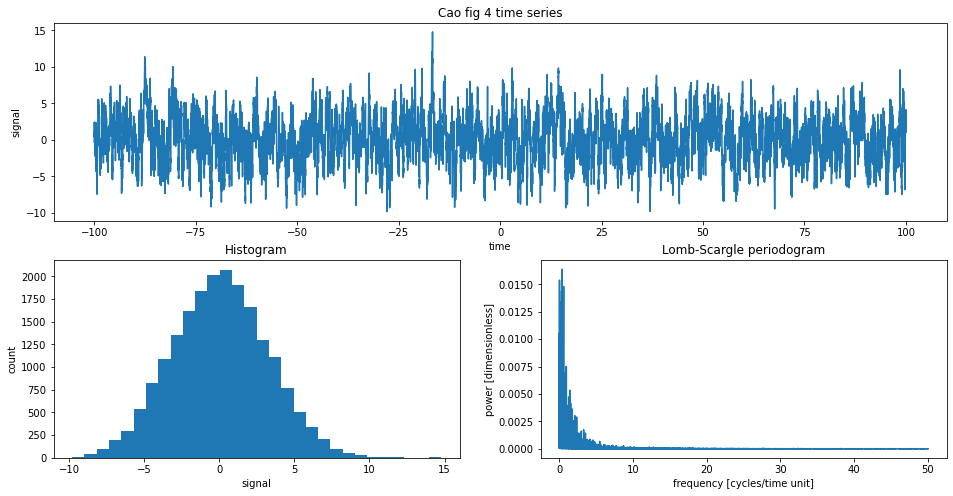

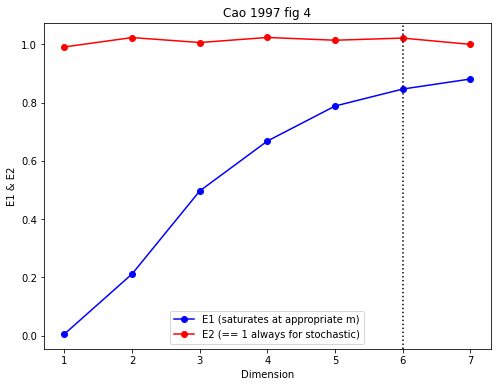

In [41]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise2 = np.random.normal(0.,1.,len(t))

caoFig4 = np.zeros_like(t)
caoFig4[0] = gaussianNoise2[0]
for i in range(1, len(t)):
    caoFig4[i] = caoFig4[i-1]*0.95 + gaussianNoise2[i]
sp.plotTimeSeries(t, caoFig4,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Cao fig 4")

# Cao used tau = 1 for this data, because it's a map rather than a continous diff EQ
E1, E2, sat_m = sp.cao97(timeSeries = caoFig4[:5000], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-',label="E1 (saturates at appropriate m)")
ax.plot(np.arange(1,8),E2,'ro',ls='-',label="E2 (== 1 always for stochastic)")
ax.axvline(sat_m, color='k',linestyle=':')
ax.set_title('Cao 1997 fig 4')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
ax.legend(loc='best',fontsize=10)
#plt.show()
plt.savefig("./plots/cao1997implementation/cao1997fig4.png")

# Calculate correlation integral

### Grassberger & Procaccia 1983

#### They advocate choosing an embedding dimension larger than strictly necessary to reduce error--interesting!

### Start with Kurths & Herzel 1987, actually.

In [3]:
logrArr = np.linspace(-4.,6.,50)
rArr = 2.**logrArr
#np.save("./corrDimTesting/rArr.npy", rArr)


In [4]:
rossler_x_f = ! ls ./corrDimTesting/rossler/rossler_x_P*.npy
rossler_y_f = ! ls ./corrDimTesting/rossler/rossler_y_P*.npy
rossler_z_f = ! ls ./corrDimTesting/rossler/rossler_z_P*.npy
rossler_f = list(rossler_x_f) + list(rossler_y_f) + list(rossler_z_f)

transformed_rossler_x_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_x_P*.npy
transformed_rossler_y_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_y_P*.npy
transformed_rossler_z_f = ! ls ./corrDimTesting/transformed_rossler/transformed_rossler_z_P*.npy
transformed_rossler_f = list(transformed_rossler_x_f) + list(transformed_rossler_y_f) + list(transformed_rossler_z_f)

lorenz_x_f = ! ls ./corrDimTesting/lorenz/lorenz_x_P*.npy
lorenz_y_f = ! ls ./corrDimTesting/lorenz/lorenz_y_P*.npy
lorenz_z_f = ! ls ./corrDimTesting/lorenz/lorenz_z_P*.npy
lorenz_f = list(lorenz_x_f) + list(lorenz_y_f) + list(lorenz_z_f)

print(len(rossler_f))
print(len(transformed_rossler_f))
print(len(lorenz_f))

81
81
81


In [5]:
for ts in transformed_rossler_f:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "transformed" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    
    mMax = int(np.floor(len(timeSeries)/bestTau))
    
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=mMax)
    
    if sat_m is None:
        print("no saturation")
        mArr = np.arange(2, mMax+1)
    else:
        if sat_m + 1 <= mMax:
            mArr = np.array((sat_m, sat_m + 1))
        elif sat_m <= mMax:
            mArr = np.array((sat_m))
        else:
            mArr = np.arange(2, mMax+1)
    
    print(mArr)
    
    for m in mArr:
        if os.path.exists("./corrDimTesting/transformed_rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m)):
            pass
        else:
            #print("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m))
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=timeSeries, tau = bestTau, m = m)
            np.save("./corrDimTesting/transformed_rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m),C0_)
            np.save("./corrDimTesting/transformed_rossler/cArrs/{0}_tau={1}_m={2}_C1.npy".format(fileName.split(".npy")[0],bestTau,m),C1_)
            np.save("./corrDimTesting/transformed_rossler/cArrs/{0}_tau={1}_m={2}_C2.npy".format(fileName.split(".npy")[0],bestTau,m),C2_)
            np.save("./corrDimTesting/transformed_rossler/cArrs/{0}_tau={1}_m={2}_nArr.npy".format(fileName.split(".npy")[0],bestTau,m),nArr_)
    

transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v0.npy


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v1.npy
[4 5]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=10_v2.npy
[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v0.npy
[4 5]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.01_Ncyc=5_v2.npy
[4 5]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[2 3]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=10_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=50_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.05_Ncyc=5_v2.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v0.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


[3 4]
transformed_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v1.npy


/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/Users/Emily/anaconda3/lib/python3.7/site-packages/pynndescent/pynndescent_.py:907: UserWarning: Failed to correctly find n_neighbors for some samples.

[4 5]
transformed_rossler_x_Pq=6.3_cad=0.1_Ncyc=10_v2.npy


ValueError: polyorder must be less than window_length.

In [ ]:
for ts in rossler_f:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "transformed" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    
    mMax = int(np.floor(len(timeSeries)/bestTau))
    
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=mMax)
    
    if sat_m is None:
        print("no saturation")
        mArr = np.arange(2, mMax+1)
    else:
        if sat_m + 1 <= mMax:
            mArr = np.array((sat_m, sat_m + 1))
        elif sat_m <= mMax:
            mArr = np.array((sat_m))
        else:
            mArr = np.arange(2, mMax+1)
    
    print(mArr)
    
    for m in mArr:
        if os.path.exists("./corrDimTesting/rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m)):
            pass
        else:
            #print("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m))
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=timeSeries, tau = bestTau, m = m)
            np.save("./corrDimTesting/rossler/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m),C0_)
            np.save("./corrDimTesting/rossler/cArrs/{0}_tau={1}_m={2}_C1.npy".format(fileName.split(".npy")[0],bestTau,m),C1_)
            np.save("./corrDimTesting/rossler/cArrs/{0}_tau={1}_m={2}_C2.npy".format(fileName.split(".npy")[0],bestTau,m),C2_)
            np.save("./corrDimTesting/rossler/cArrs/{0}_tau={1}_m={2}_nArr.npy".format(fileName.split(".npy")[0],bestTau,m),nArr_)
    

In [ ]:
for ts in lorenz_f:
    #print(ts)
    timeSeries = np.load(ts)
    
    fileName = ts.split("/")[-1]
    print(fileName)
    
    timeFileName = fileName.split("Pq")[0] + "t_Pq" + fileName.split("Pq")[1]
    #print(timeFileName)

    time = np.load("/".join(ts.split("/")[:-1]) + "/" + timeFileName)
    
    if "transformed" in fileName:
        varname = fileName.split("_")[2]
    else:
        varname = fileName.split("_")[1]
    #print(varname)
    details = "Pq" + fileName.split("Pq")[1].split(".npy")[0]
    #print(details)
    Pq = float(details.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(details.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(details.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(details.split("_v")[1])
    #print(version)
    
    bestTau = sp.FS86(time=time, timeSeries=timeSeries, plot=False)[1]
    
    mMax = int(np.floor(len(timeSeries)/bestTau))
    
    E1, E2, sat_m = sp.cao97(timeSeries=timeSeries, tau=bestTau, mMax=mMax)
    
    if sat_m is None:
        print("no saturation")
        mArr = np.arange(2, mMax+1)
    else:
        if sat_m + 1 <= mMax:
            mArr = np.array((sat_m, sat_m + 1))
        elif sat_m <= mMax:
            mArr = np.array((sat_m))
        else:
            mArr = np.arange(2, mMax+1)
    
    print(mArr)
    
    for m in mArr:
        if os.path.exists("./corrDimTesting/lorenz/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m)):
            pass
        else:
            #print("./corrDimTesting/{0}_tau={1}_m={2}_C0.npy".format(fileName,bestTau,m))
            C0_, C1_, C2_, nArr_ = sp.Cq(rArr=rArr, timeSeries=timeSeries, tau = bestTau, m = m)
            np.save("./corrDimTesting/lorenz/cArrs/{0}_tau={1}_m={2}_C0.npy".format(fileName.split(".npy")[0],bestTau,m),C0_)
            np.save("./corrDimTesting/lorenz/cArrs/{0}_tau={1}_m={2}_C1.npy".format(fileName.split(".npy")[0],bestTau,m),C1_)
            np.save("./corrDimTesting/lorenz/cArrs/{0}_tau={1}_m={2}_C2.npy".format(fileName.split(".npy")[0],bestTau,m),C2_)
            np.save("./corrDimTesting/lorenz/cArrs/{0}_tau={1}_m={2}_nArr.npy".format(fileName.split(".npy")[0],bestTau,m),nArr_)
    

## Plot results of multiple runs

In [42]:
rArr = np.load("./corrDimTesting/rArr.npy")

In [43]:
rossler_x_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_x_P*C0.npy
rossler_y_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_y_P*C0.npy
rossler_z_C0 = ! ls ./corrDimTesting/rossler/cArrs/rossler_z_P*C0.npy
rossler_C0 = list(rossler_x_C0) + list(rossler_y_C0) + list(rossler_z_C0)

transformed_rossler_x_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_x_P*C0.npy
transformed_rossler_y_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_y_P*C0.npy
transformed_rossler_z_C0 = ! ls ./corrDimTesting/transformed_rossler/cArrs/transformed_rossler_z_P*C0.npy
transformed_rossler_C0 = list(transformed_rossler_x_C0) + list(transformed_rossler_y_C0) + list(transformed_rossler_z_C0)

lorenz_x_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_x_P*C0.npy
lorenz_y_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_y_P*C0.npy
lorenz_z_C0 = ! ls ./corrDimTesting/lorenz/cArrs/lorenz_z_P*C0.npy
lorenz_C0 = list(lorenz_x_C0) + list(lorenz_y_C0) + list(lorenz_z_C0)

print(len(rossler_C0))
print(len(transformed_rossler_C0))
print(len(lorenz_C0))

162
162
183


# Trying new way of calculating dimension---instead of fitting a single power-law slope to C2 vs r, how about fitting an individual power law slope to each n_i(r) vs r, then looking at the distribution of resulting slopes?

In [44]:
#import warnings
#warnings.filterwarnings("ignore")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 957
Maximal epsilon in the moment= 2.058961e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.058961e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 957
Maximal epsilon in the moment= 2.453053e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.453053e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 951
Maximal epsilon in the moment= 2.417123e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 927
Maximal epsilon in the moment= 2.417123e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4953
Maximal epsilon in the moment= 2.447016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4930
Maximal epsilon in the moment= 2.447016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.439542e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.439542e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 433
Maximal epsilon in the moment= 2.434025e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 411
Maximal epsilon in the moment= 2.434025e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 441
Maximal epsilon in the moment= 2.379768e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 412
Maximal epsilon in the moment= 2.379768e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 457
Maximal epsilon in the moment= 2.428190e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 436
Maximal epsilon in the moment= 2.428190e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 475
Maximal epsilon in the moment= 2.058417e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 2.058417e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.400320e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 455
Maximal epsilon in the moment= 2.400320e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 2.408036e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.408036e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2479
Maximal epsilon in the moment= 2.436608e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2469
Maximal epsilon in the moment= 2.436608e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2479
Maximal epsilon in the moment= 2.426832e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2469
Maximal epsilon in the moment= 2.426832e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.439916e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 223
Maximal epsilon in the moment= 2.432586e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 210
Maximal epsilon in the moment= 2.432586e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 216
Maximal epsilon in the moment= 2.316121e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 205
Maximal epsilon in the moment= 2.316121e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 219
Maximal epsilon in the moment= 2.393344e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 209
Maximal epsilon in the moment= 2.393344e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.037398e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.037398e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 81
Maximal epsilon in the moment= 1.811925e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 75
Maximal epsilon in the moment= 1.811925e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 97
Maximal epsilon in the moment= 2.028467e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.028467e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.433683e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.433683e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.414194e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.414194e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.431270e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.431270e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.592709e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 41
Maximal epsilon in the moment= 1.592709e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 48
Maximal epsilon in the moment= 1.420896e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 47
Maximal epsilon in the moment= 1.420896e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.985257e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 41
Maximal epsilon in the moment= 1.985257e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 955
Maximal epsilon in the moment= 2.697621e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 933
Maximal epsilon in the moment= 2.697621e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 936
Maximal epsilon in the moment= 2.654771e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 915
Maximal epsilon in the moment= 2.654771e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 933
Maximal epsilon in the moment= 2.639137e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 911
Maximal epsilon in the moment= 2.639137e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4951
Maximal epsilon in the moment= 2.693977e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4927
Maximal epsilon in the moment= 2.693977e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4930
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4907
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 2.687981e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 2.687981e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 301
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 235
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 445
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 449
Maximal epsilon in the moment= 2.239211e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 424
Maximal epsilon in the moment= 2.239211e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 2.638891e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 2.638891e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 469
Maximal epsilon in the moment= 2.609598e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 459
Maximal epsilon in the moment= 2.609598e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 481
Maximal epsilon in the moment= 2.618000e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 472
Maximal epsilon in the moment= 2.618000e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.671112e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.671112e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2455
Maximal epsilon in the moment= 2.681887e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2477
Maximal epsilon in the moment= 2.687428e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2466
Maximal epsilon in the moment= 2.687428e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 147
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 113
Maximal epsilon in the moment= 2.247216e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 229
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 219
Maximal epsilon in the moment= 2.586438e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 225
Maximal epsilon in the moment= 2.216531e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 213
Maximal epsilon in the moment= 2.216531e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.009808e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.009808e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 2.600263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 2.600263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 81
Maximal epsilon in the moment= 1.962948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 75
Maximal epsilon in the moment= 1.962948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.648946e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.648946e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.586215e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.586215e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 2.555591e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 2.555591e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 2.117948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 2.117948e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 45
Maximal epsilon in the moment= 2.497843e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 2.497843e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 2.150019e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 2.150019e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 949
Maximal epsilon in the moment= 1.664263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 924
Maximal epsilon in the moment= 1.664263e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 949
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 924
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 951
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 927
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4951
Maximal epsilon in the moment= 1.669477e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4927
Maximal epsilon in the moment= 1.669477e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4955
Maximal epsilon in the moment= 1.671745e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4933
Maximal epsilon in the moment= 1.671745e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4949
Maximal epsilon in the moment= 1.671841e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 4924
Maximal epsilon in the moment= 1.671841e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 451
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 427
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 424
Maximal epsilon in the moment= 1.647932e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 399
Maximal epsilon in the moment= 1.647932e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 427
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 403
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 1.663568e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 1.663568e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 477
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 466
Maximal epsilon in the moment= 1.661224e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 475
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 463
Maximal epsilon in the moment= 1.667650e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.669388e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.669388e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.671710e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.671710e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2475
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 2463
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 223
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 210
Maximal epsilon in the moment= 1.584724e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 225
Maximal epsilon in the moment= 1.644936e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 213
Maximal epsilon in the moment= 1.644936e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 227
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 216
Maximal epsilon in the moment= 1.655086e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 97
Maximal epsilon in the moment= 1.649167e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.649167e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.652562e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 1.652562e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 96
Maximal epsilon in the moment= 1.658963e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 95
Maximal epsilon in the moment= 1.658963e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.655111e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.655111e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.666654e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.666654e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 496
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 495
Maximal epsilon in the moment= 1.671045e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 45
Maximal epsilon in the moment= 1.546016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 43
Maximal epsilon in the moment= 1.546016e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 47
Maximal epsilon in the moment= 1.597902e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 46
Maximal epsilon in the moment= 1.597902e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 37
Maximal epsilon in the moment= 1.648759e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater



Additional non-data files were created
	Nonsilent mode chosen, displaying additional content:

File outFile.stat contains:
Center points treated so far= 31
Maximal epsilon in the moment= 1.648759e+01



/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


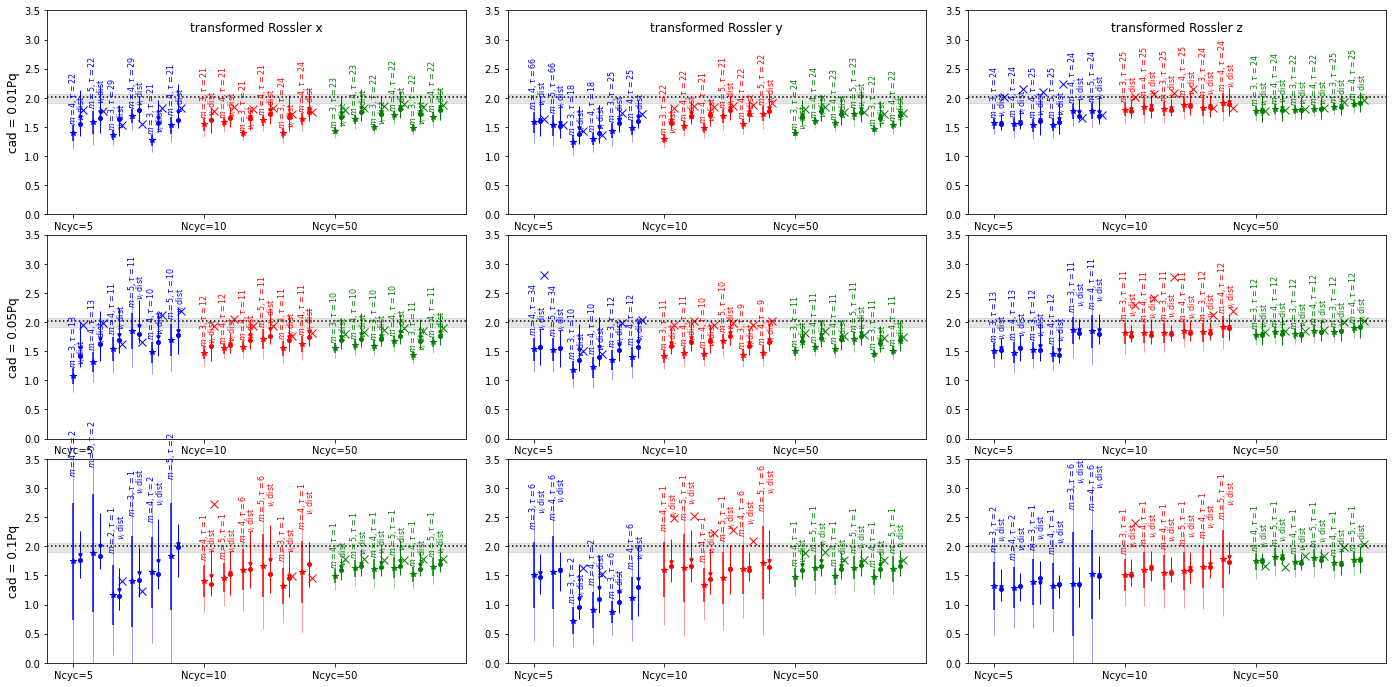

In [45]:
# "true" C2 values from Sprott & Rowlands 2000
lorenz_C2_lower = 2.049-0.096
lorenz_C2_upper = 2.049+0.096
lorenz_KY = 2.062
rossler_C2_lower = 1.986-0.078
rossler_C2_upper = 1.986+0.078
rossler_KY = 2.013

fig, axes = plt.subplots(3,3,figsize=(24,12))
counters = np.zeros((3,3,3))
for f in transformed_rossler_C0:
    #print(f)
    #C0 = np.load(f)
    #C1 = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2 = np.load(f[:-6] + "C2.npy")
    nArr = np.load(f[:-6] + "nArr.npy")
    #print(np.shape(nArr))
    
    Pq = float(f.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(f.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(f.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(f.split("_v")[1].split("_")[0])
    #print(version)
    tau = int(f.split("tau=")[1].split("_")[0])
    #print(tau)
    m = int(f.split("m=")[1].split("_")[0])
    #print(m)
    
    varname = f.split("transformed_rossler_")[1][0]
    
    ts_f = "./corrDimTesting/transformed_rossler/transformed_rossler_{0}_Pq={1}_cad={2}_Ncyc={3}_v{4}.npy".format(varname,Pq,cad,Ncyc,version)
    
    timeSeries = np.load(ts_f)
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)
        
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    #enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    #firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    #anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    #anyNans = np.array(anyNans)
    #nansIdxs = np.arange(len(rArr))[anyNans]
    #lastGood = nansIdxs[0]
    
    # My code to calculate C2
    try:
        params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
        params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
    except IndexError:
        params_C2 = np.zeros_like(params_C2)
        params_unc_C2 = np.zeros_like(params_unc_C2)
        params_C2[:] = np.nan
        params_unc_C2[:] = np.nan
        
        params_dist = np.zeros_like(params_dist)
        params_dist_1sigma = np.zeros_like(params_dist_1sigma)
        params_dist[:] = np.nan
        params_dist_1sigma[:] = np.nan
    
    #TISEAN C2 calculation
    # Multiple output command example (d2)
    d2_out, msg = tiseanio("d2", '-N', '0', '-M', '1,{0}'.format(m), '-d', '{0}'.format(tau), "-V", "0", data=timeSeries)
    
    # need to figure out the Thelier window but just in the interest of getting the plotting code working:
    """
    fig3,ax3 = plt.subplots(1,1,figsize=(8,6))
    ax3.plot(d2_out["c2"][:,0])
    plt.show()
    """
    tisean_r_arr = d2_out["c2"][-78:-42,0][::-1]
    tisean_C2_arr = d2_out["c2"][-78:-42:,1][::-1]
    
    tisean_params, tisean_params_unc = sp.normal_equation(x=np.log10(tisean_r_arr), y=np.log10(tisean_C2_arr), yerr=np.ones_like(tisean_C2_arr), order=2)
    
    """
    fig2, axes2 = plt.subplots(2,1,figsize=(8,12))
    axes2[0].scatter(d2_out["c2"][:,0], d2_out["c2"][:,1],s=5)
    axes2[0].scatter(tisean_r_arr,tisean_C2_arr,s=10,color='y',alpha=0.5)

    axes2[0].set_yscale('log')
    axes2[0].set_ylim([1e-7,1])
    axes2[0].set_xscale('log')
    axes2[0].set_xlabel("length scale")
    axes2[0].set_ylabel("correlation sum")

    # plot output d2
    axes2[1].scatter(d2_out["d2"][:,0], d2_out["d2"][:,1],s=5)
    #axes2[1].set_yscale('log')
    axes2[1].set_xscale('log')
    axes2[1].set_xlabel("length scale")
    axes2[1].set_ylabel("correlation dimension")
    plt.show()
    """
    
    
    """
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for i in range(len(params_dist)):
        #ax.plot(rArr, nArr[i], 'k-', marker='None', lw=1, alpha=0.1)
        #ax.plot(rArr[firstGood:lastGood], nArr[i][firstGood:lastGood], 'k-', marker='None', lw=1, alpha=0.1)
        ax.plot(rArr[firstGood:lastGood], (10**params_dist[i][1])*rArr[firstGood:lastGood]**params_dist[i][0], 'r-', marker='None', lw=1, alpha=0.1)
    #ax.plot(rArr, C2, 'ko', ls="None")
    ax.plot(rArr[firstGood:lastGood], C2[firstGood:lastGood], 'ko', ls="None")
    print(params_C2[1])
    ax.plot(rArr[firstGood:lastGood], (10**params_C2[1])*rArr[firstGood:lastGood]**params_C2[0], 'b-', marker='None', lw=2, alpha=1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.show()
    """
    
    if cad==0.01:
        idx_0 = 0
    elif cad==0.05:
        idx_0 = 1
    elif cad==0.1:
        idx_0 = 2

    if "_x_" in f:
        idx_1 = 0
    elif "_y_" in f:
        idx_1 = 1
    elif "_z_" in f:
        idx_1 = 2

    if Ncyc==5:
        start_x = 1
        color = 'b'
        idx_2 = 0
    elif Ncyc==10:
        start_x = 2
        color = 'r'
        idx_2 = 1
    elif Ncyc==50:
        start_x = 3
        color = 'g'
        idx_2 = 2

    #
    #for i in range(len(params_dist)):
    #    axes[idx_0,idx_1].plot(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_dist[i][0],marker='o', color='k',ms=3,alpha=0.05,zorder=i)
    
    # my C2 calculation overall
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], np.sqrt(params_unc_C2[0,0]), marker='*', color=color, elinewidth=1.5,alpha=1.,zorder=2)
    axes[idx_0,idx_1].errorbar(start_x + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0], 2*np.sqrt(params_unc_C2[0,0]), marker='None', color=color, elinewidth=0.75,alpha=0.5,zorder=1)
    
    p16 = np.percentile(params_dist[:,0],16)
    p50 = np.percentile(params_dist[:,0],50)
    v_mean = np.mean(params_dist[:,0])
    p84 = np.percentile(params_dist[:,0],84)
    
    #my C2 calculation from the v_i distribution
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],p50, marker='o',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    axes[idx_0,idx_1].plot(start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2],v_mean, marker='*',ms=4,color=color,lw=1.,alpha=1,zorder=2)
    axes[idx_0,idx_1].vlines(x=start_x + 0.05 + 0.15*counters[idx_0,idx_1,idx_2], ymin=p16, ymax=p84, color=color,lw=1.,alpha=1,zorder=1)
    
    #TISEAN 
    axes[idx_0,idx_1].plot(start_x + 0.075 + 0.15*counters[idx_0,idx_1,idx_2],tisean_params[0], marker='x',ms=8,color=color,lw=1.,alpha=1,zorder=2)
    
    axes[idx_0,idx_1].annotate(r"$m={0},\tau={1}$".format(m,tau), (start_x -0.05 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+1.5*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   
    axes[idx_0,idx_1].annotate(r"$\nu_i$ dist".format(m,tau), (start_x + 0.02 + 0.15*counters[idx_0,idx_1,idx_2], params_C2[0]+2*np.sqrt(params_unc_C2[0,0])),rotation=90,color=color,fontsize=8,zorder=3)   

    counters[idx_0,idx_1,idx_2] += 1


axes[0,0].set_ylabel("cad = 0.01Pq", fontsize=12)
axes[1,0].set_ylabel("cad = 0.05Pq", fontsize=12)
axes[2,0].set_ylabel("cad = 0.1Pq", fontsize=12)


axes[0,0].set_title("transformed Rossler x", fontsize=12)
axes[0,1].set_title("transformed Rossler y", fontsize=12)
axes[0,2].set_title("transformed Rossler z", fontsize=12)

x_fb = np.linspace(0.,4.,3)

for ax in np.ravel(axes):
    ax.fill_between(x = x_fb, y1 = rossler_C2_lower*np.ones_like(x_fb), y2 = rossler_C2_upper*np.ones_like(x_fb), color='k',alpha=0.1,zorder=1)
    ax.axhline(y=rossler_KY, ls=":", color='k',zorder=2)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(["Ncyc=5","Ncyc=10","Ncyc=50"])
    ax.set_xlim(0.8,4.)
    ax.set_ylim(0.,3.5)
    

plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.show()
plt.savefig("./plots/gp1983implementation/transformed_rossler_recoveredPowerLawSlope_severalTrials.pdf")


# Colormap delay diagrams by recovered dimension

In [46]:
for f in transformed_rossler_C0:
    #print(f)
    #C0 = np.load(f)
    #C1 = np.load("./corrDimTesting/" + fileName[:-2] + "C1.npy")
    C2 = np.load(f[:-6] + "C2.npy")
    nArr = np.load(f[:-6] + "nArr.npy")
    #print(np.shape(nArr))
    
    tsName = "/".join(f.split("/")[0:3]) +"/"+ f.split("/")[-1].split("_tau")[0] + ".npy"
    ts = np.load(tsName)
    
    Pq = float(f.split("Pq=")[1].split("_")[0])
    #print(Pq)
    cad = float(f.split("cad=")[1].split("_")[0])
    #print(cad)
    Ncyc = int(f.split("Ncyc=")[1].split("_")[0])
    #print(Ncyc)
    version = int(f.split("_v")[1].split("_")[0])
    #print(version)
    tau = int(f.split("tau=")[1].split("_")[0])
    print(tau)
    m = int(f.split("m=")[1].split("_")[0])
    #print(m)
    
    if "transformed" in f:
        varname = " ".join(f.split("/")[-1].split("_")[0:3])
    else:
        varname = " ".join(f.split("/")[-1].split("_")[0:2])
    
    delayMat = sp.delayMatrix(ts, tau, m)
    #print(np.shape(delayMat))
    
    N = np.shape(nArr)[0]
    medians = np.percentile(nArr, 50, axis=0)
        
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    anyNans = np.array(anyNans)
    nansIdxs = np.arange(len(rArr))[anyNans]
    lastGood = nansIdxs[0]
    
    params_C2, params_unc_C2 = sp.fitLinearRegime(rArr, nArr, C2)
    
    params_dist, params_dist_1sigma = sp.powerLawSlopeDistribution(rArr, nArr)
          
    #print(np.shape(params_dist))
    #print(np.shape(params_dist[:,0]))
    
    fig, axes = plt.subplots(m,1,figsize=(6, 6*(m-1)))
    axes = np.atleast_1d(axes)
    for j in range(1,m):
        axes[m-1-j].plot(delayMat[:,0],delayMat[:,j],linestyle='-',color='k',lw=0.25,marker="None",zorder=1)
        im = axes[m-1-j].scatter(delayMat[:,0],delayMat[:,j],c=params_dist[:,0],s=10,cmap="magma",linewidths=0,alpha=0.9,zorder=2)
        
        divider = make_axes_locatable(axes[m-1-j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
        
        axes[m-1-j].set_ylabel(r"{0}$_i + {1}\tau$".format(varname,j),fontsize=14)
    
    axes[m-2].set_xlabel(r"{0}$_i$".format(varname),fontsize=14)
    
    im = axes[m-1].scatter(np.arange(0,len(delayMat[:,0])), delayMat[:,0], c=params_dist[:,0],s=10,cmap="magma")
    divider = make_axes_locatable(axes[m-1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(label=r"Power law slope fit to $n(x_i)$ vs. $r$",fontsize=14)
    axes[m-1].set_ylabel(r"{0}$_i$".format(varname),fontsize=14)
    axes[m-1].set_xlabel("i", fontsize=14)
    
    n_t = len(delayMat[:,0])//tau
    
    for k in range(n_t+1):
        axes[m-1].axvline(k*tau, color='k', ls="-",lw=0.5)
    
    plt.subplots_adjust(hspace=0.2)
    #plt.show()
    plt.savefig("./plots/gp1983implementation/transformed_rossler/{0}.png".format(f.split("/")[-1][:-7]),dpi=300)
    plt.close()


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


23


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


23


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


29


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


29


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


13


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


13


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


21


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


23


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


23


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


66


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


66


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


18


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


18


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


9


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


9


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


34


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


34


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


10


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


22


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


25


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


24


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


13


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


13


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


12


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


11


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


2


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


1


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


6


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


## Old

In [ ]:
"""
combos = [(15,3),(60,3),(15,4),(60,4)]
C0_1000 = [C0_1000_t15_m3, C0_1000_t60_m3, C0_1000_t15_m4, C0_1000_t60_m4]
C1_1000 = [C1_1000_t15_m3, C1_1000_t60_m3, C1_1000_t15_m4, C1_1000_t60_m4]
C2_1000 = [C2_1000_t15_m3, C2_1000_t60_m3, C2_1000_t15_m4, C2_1000_t60_m4]
n_1000 = [nArr_1000_t15_m3, nArr_1000_t60_m3, nArr_1000_t15_m4, nArr_1000_t60_m4]

C0_5000 = [C0_5000_t15_m3, C0_5000_t60_m3, C0_5000_t15_m4, C0_5000_t60_m4]
C1_5000 = [C1_5000_t15_m3, C1_5000_t60_m3, C1_5000_t15_m4, C1_5000_t60_m4]
C2_5000 = [C2_5000_t15_m3, C2_5000_t60_m3, C2_5000_t15_m4, C2_5000_t60_m4]
n_5000 = [nArr_5000_t15_m3, nArr_5000_t60_m3, nArr_5000_t15_m4, nArr_5000_t60_m4]

C0_10000 = [C0_10000_t15_m3, C0_10000_t60_m3, C0_10000_t15_m4, C0_10000_t60_m4]
C1_10000 = [C1_10000_t15_m3, C1_10000_t60_m3, C1_10000_t15_m4, C1_10000_t60_m4]
C2_10000 = [C2_10000_t15_m3, C2_10000_t60_m3, C2_10000_t15_m4, C2_10000_t60_m4]
n_10000 = [nArr_10000_t15_m3, nArr_10000_t60_m3, nArr_10000_t15_m4, nArr_10000_t60_m4]

C0_20000 = [C0_20000_t15_m3, C0_20000_t60_m3, C0_20000_t15_m4, C0_20000_t60_m4]
C1_20000 = [C1_20000_t15_m3, C1_20000_t60_m3, C1_20000_t15_m4, C1_20000_t60_m4]
C2_20000 = [C2_20000_t15_m3, C2_20000_t60_m3, C2_20000_t15_m4, C2_20000_t60_m4]
n_20000 = [nArr_20000_t15_m3, nArr_20000_t60_m3, nArr_20000_t15_m4, nArr_20000_t60_m4]

# vertical offsets for the different-length time series
vOffset = [10**7, 10**5, 10**3, 10**1]

# adjustments to vertical offsets for the different choices of tau and m
bOffset = [10**-2.45,10**-3,10**-2.75,10**-3.25]
Narr = [(970,4970,9970,19970),(880,4880,9880,19880),(955,4995,9955,19955),(820,4820,9820,19820)]


for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    
    p84_1000 = np.percentile(n_1000[i], 84, axis=0)
    p50_1000 = np.percentile(n_1000[i], 50, axis=0)
    p16_1000 = np.percentile(n_1000[i], 16, axis=0)
    
    p84_5000 = np.percentile(n_5000[i], 84, axis=0)
    p50_5000 = np.percentile(n_5000[i], 50, axis=0)
    p16_5000 = np.percentile(n_5000[i], 16, axis=0)
    
    p84_10000 = np.percentile(n_10000[i], 84, axis=0)
    p50_10000 = np.percentile(n_10000[i], 50, axis=0)
    p16_10000 = np.percentile(n_10000[i], 16, axis=0)
    
    p84_20000 = np.percentile(n_20000[i], 84, axis=0)
    p50_20000 = np.percentile(n_20000[i], 50, axis=0)
    p16_20000 = np.percentile(n_20000[i], 16, axis=0)
    
    fig, axes = plt.subplots(3,1,figsize=(12,24))
    
    axes[0].plot(rArr,C0_1000[i] * vOffset[0],color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")    
    axes[0].plot(rArr,C1_1000[i] * vOffset[0],color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[0].plot(rArr,C2_1000[i] * vOffset[0],color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[0].vlines(x=rArr, ymin=p16_1000 * vOffset[0], ymax=p84_1000 * vOffset[0], color='b',lw=1)
    
    axes[0].plot(rArr,C0_5000[i] * vOffset[1],color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[0].plot(rArr,C1_5000[i] * vOffset[1],color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[0].plot(rArr,C2_5000[i] * vOffset[1],color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[0].vlines(x=rArr, ymin=p16_5000 * vOffset[1], ymax=p84_5000 * vOffset[1], color='r',lw=1)
    
    axes[0].plot(rArr,C0_10000[i]* vOffset[2],color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[0].plot(rArr,C1_10000[i]* vOffset[2],color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[0].plot(rArr,C2_10000[i]* vOffset[2],color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[0].vlines(x=rArr, ymin=p16_10000 * vOffset[2], ymax=p84_10000 * vOffset[2], color='g',lw=1)
    
    axes[0].plot(rArr,C0_20000[i]* vOffset[3],color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[0].plot(rArr,C1_20000[i]* vOffset[3],color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[0].plot(rArr,C2_20000[i]* vOffset[3],color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[0].vlines(x=rArr, ymin=p16_20000 * vOffset[3], ymax=p84_20000 * vOffset[3], color='m',lw=1)
    
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[0],'b-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[1],'r-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[2],'g-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[3],'m-',lw=1)

    axes[0].text(10.,vOffset[0]*0.5,r"$r^{2.06}$",color='b',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[1]*0.5,r"$r^{2.06}$",color='r',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[2]*0.5,r"$r^{2.06}$",color='g',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[3]*0.5,r"$r^{2.06}$",color='m',fontsize=14,rotation=20)
    
    axes[0].set_ylabel(r"$\log_{10}[C(r)]$", fontsize=16)
    axes[0].set_title(r"Lorenz $x$ $C_2(r)$ tau={0}, m={1}; cf GP83 fig. 1".format(t,m),fontsize=16)
    axes[0].set_yscale("log")
    axes[0].set_ylim(1.e-6,1.e8)
    axes[0].set_yticklabels([-8,-6,-4,-2,0,2,4,6,8])
    
    # residuals compared to power law
    axes[1].plot(rArr,np.log10(C0_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[1].plot(rArr,np.log10(C1_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[1].plot(rArr,np.log10(C2_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='b',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[1].plot(rArr,np.log10(C1_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[1].plot(rArr,np.log10(C2_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='r',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[1].plot(rArr,np.log10(C1_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[1].plot(rArr,np.log10(C2_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='g',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[1].plot(rArr,np.log10(C1_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[1].plot(rArr,np.log10(C2_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='m',lw=1.,alpha=1)
    
    axes[1].axhline(0,color='k',ls=':')
    axes[1].set_title(r"residuals compared to $r^{2.06}$ power law ($\log_{10}$ space)",fontsize=16)
    
    # residuals compared to 20000 data points
    axes[2].plot(rArr,np.log10(C0_1000[i]) - np.log10(C0_20000[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[2].plot(rArr,np.log10(C1_1000[i]) - np.log10(C1_20000[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[2].plot(rArr,np.log10(C2_1000[i]) - np.log10(C2_20000[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(C1_20000[i]), ymax=np.log10(p84_1000)-np.log10(C1_20000[i]), color='b',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_5000[i]) - np.log10(C0_20000[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[2].plot(rArr,np.log10(C1_5000[i]) - np.log10(C1_20000[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[2].plot(rArr,np.log10(C2_5000[i]) - np.log10(C2_20000[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(C1_20000[i]), ymax=np.log10(p84_5000)-np.log10(C1_20000[i]), color='r',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_10000[i]) - np.log10(C0_20000[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[2].plot(rArr,np.log10(C1_10000[i]) - np.log10(C1_20000[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[2].plot(rArr,np.log10(C2_10000[i]) - np.log10(C2_20000[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(C1_20000[i]), ymax=np.log10(p84_10000)-np.log10(C1_20000[i]), color='g',lw=1.,alpha=1)
    
    axes[2].axhline(0,color='k',ls=':')
    axes[2].set_title(r"residuals compared to 20000 data points ($\log_{10}$ space)",fontsize=16)
    

    for ax in axes:
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlabel(r"$\log_{10}[r]$", fontsize=16)
        ax.set_xscale("log")
        ax.set_xlim(5.e-2,1.e2)
        ax.set_xticklabels([-3,-2,-1,0,1,2])
        ax.legend(loc="lower right",frameon=True,framealpha=1.0, edgecolor='None')
    
    #plt.show()
    plt.savefig("./plots/gp1983implementation/lorenz_x_timeSeriesLength_tau={0}_m={1}.pdf".format(t,m))
"""

In [ ]:
'''
fig, axes = plt.subplots(4,1,figsize=(4,10))#plt.subplots(4,3,figsize=(8,8))

for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    """
    params_1000_C0, params_unc_1000_C0 = sp.fitLinearRegime(rArr, n_1000[i], C0_1000[i])
    params_5000_C0, params_unc_5000_C0 = sp.fitLinearRegime(rArr, n_5000[i], C0_5000[i])
    params_10000_C0, params_unc_10000_C0 = sp.fitLinearRegime(rArr, n_10000[i], C0_10000[i])
    params_20000_C0, params_unc_20000_C0 = sp.fitLinearRegime(rArr, n_20000[i], C0_20000[i])
    
    params_1000_C1, params_unc_1000_C1 = sp.fitLinearRegime(rArr, n_1000[i], C1_1000[i])
    params_5000_C1, params_unc_5000_C1 = sp.fitLinearRegime(rArr, n_5000[i], C1_5000[i])
    params_10000_C1, params_unc_10000_C1 = sp.fitLinearRegime(rArr, n_10000[i], C1_10000[i])
    params_20000_C1, params_unc_20000_C1 = sp.fitLinearRegime(rArr, n_20000[i], C1_20000[i])
    """
    params_1000_C2, params_unc_1000_C2 = sp.fitLinearRegime(rArr, n_1000[i], C2_1000[i])
    params_5000_C2, params_unc_5000_C2 = sp.fitLinearRegime(rArr, n_5000[i], C2_5000[i])
    params_10000_C2, params_unc_10000_C2 = sp.fitLinearRegime(rArr, n_10000[i], C2_10000[i])
    params_20000_C2, params_unc_20000_C2 = sp.fitLinearRegime(rArr, n_20000[i], C2_20000[i])
    """
    axes[i,0].axhline(2.06,color='k',linestyle=":")
    axes[i,0].errorbar(1, params_1000_C0[0], np.sqrt(params_unc_1000_C0[0,0]), marker='.', color='b', elinewidth=1,label='1000 points')
    axes[i,0].errorbar(2, params_5000_C0[0], np.sqrt(params_unc_5000_C0[0,0]), marker='.', color='r', elinewidth=1, label='5000 points')
    axes[i,0].errorbar(3, params_10000_C0[0], np.sqrt(params_unc_10000_C0[0,0]), marker='.', color='g', elinewidth=1, label='10000 points')
    axes[i,0].errorbar(4, params_20000_C0[0], np.sqrt(params_unc_20000_C0[0,0]), marker='.', color='m', elinewidth=1, label='20000 points')
    axes[i,0].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i,0].set_xticks([])
    axes[i,0].set_ylim(1.25,3)
    
    axes[i,1].axhline(2.06,color='k',linestyle=":")
    axes[i,1].errorbar(1, params_1000_C1[0], np.sqrt(params_unc_1000_C1[0,0]), marker='o', color='b', elinewidth=1,label='1000 points')
    axes[i,1].errorbar(2, params_5000_C1[0], np.sqrt(params_unc_5000_C1[0,0]), marker='o', color='r', elinewidth=1, label='5000 points')
    axes[i,1].errorbar(3, params_10000_C1[0], np.sqrt(params_unc_10000_C1[0,0]), marker='o', color='g', elinewidth=1, label='10000 points')
    axes[i,1].errorbar(4, params_20000_C1[0], np.sqrt(params_unc_20000_C1[0,0]), marker='o', color='m', elinewidth=1, label='20000 points')
    axes[i,1].set_xticks([])
    axes[i,1].set_ylim(1.25,3)
    """
    axes[i].axhline(2.06,color='k',linestyle=":")
    axes[i].errorbar(1, params_1000_C2[0], np.sqrt(params_unc_1000_C2[0,0]), marker='*', color='b', elinewidth=1,label='1000 points')
    axes[i].errorbar(2, params_5000_C2[0], np.sqrt(params_unc_5000_C2[0,0]), marker='*', color='r', elinewidth=1, label='5000 points')
    axes[i].errorbar(3, params_10000_C2[0], np.sqrt(params_unc_10000_C2[0,0]), marker='*', color='g', elinewidth=1, label='10000 points')
    axes[i].errorbar(4, params_20000_C2[0], np.sqrt(params_unc_20000_C2[0,0]), marker='*', color='m', elinewidth=1, label='20000 points')
    axes[i].set_xticks([])
    axes[i].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i].set_ylim(1.25,3)
    
axes[0].legend(fontsize=8,loc='upper right', frameon=False)

#axes[0,0].set_title("C0")
#axes[0,1].set_title("C1")
axes[0].set_title("C2")
plt.subplots_adjust(hspace=0.1,wspace=0.4)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_x_recoveredPowerLawSlope.pdf")
'''

In [90]:
x = np.load("./corrDimTesting/rossler/rossler_x_Pq=6.3_cad=0.01_Ncyc=50_v0.npy")
tx = np.load("./corrDimTesting/rossler/rossler_x_t_Pq=6.3_cad=0.01_Ncyc=50_v0.npy")
z = np.load("./corrDimTesting/rossler/rossler_z_Pq=5.9_cad=0.01_Ncyc=50_v0.npy")
tz = np.load("./corrDimTesting/rossler/rossler_z_t_Pq=5.9_cad=0.01_Ncyc=50_v0.npy")

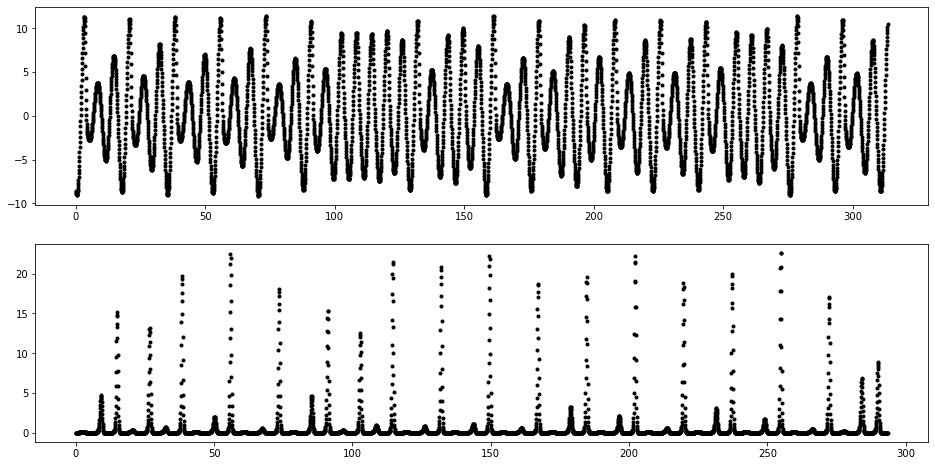

In [91]:
fig, axes = plt.subplots(2,1,figsize=(16,8))

axes[0].plot(tx,x,'k.')
axes[1].plot(tz,z,'k.')
plt.show()

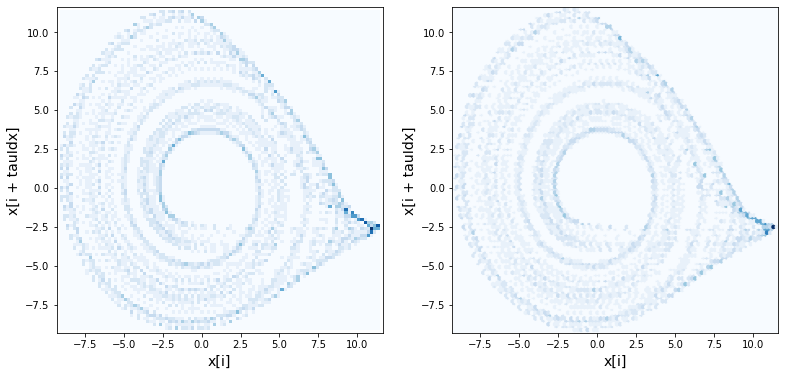

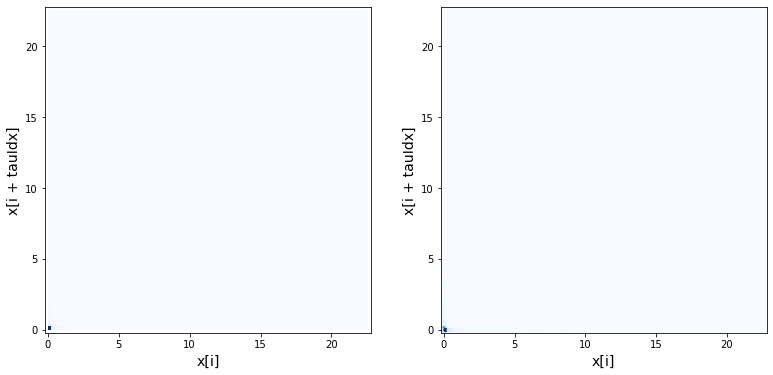

In [92]:
sp.bin2D(x, tauIdx=25)

sp.bin2D(z, tauIdx=35)

[0.02482953 0.02538484 0.02599349 ... 0.02450029 0.02223498 0.02074599]
[0.12643555 0.13298779 0.13942316 ... 0.0232138  0.02423715 0.02538302]


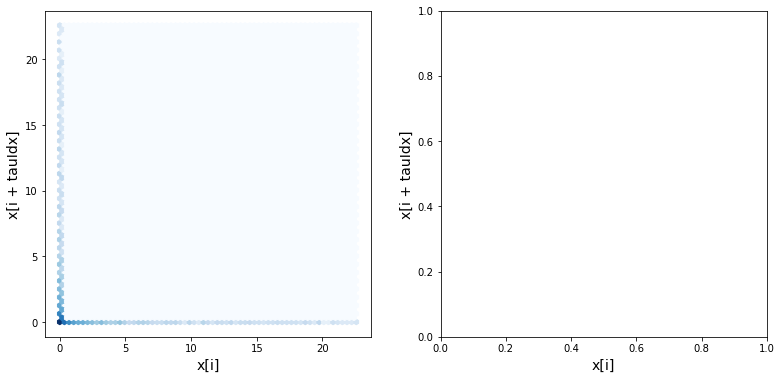

In [97]:
zx = z[:-35]
zy = z[35:]
print(zx)
print(zy)
fig, axes = plt.subplots(1,2,figsize=(13,6))
axes[0].hexbin(zx,zy,bins='log',gridsize=64,cmap="Blues")

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlabel("x[i]",fontsize=14)
    ax.set_ylabel("x[i + tauIdx]",fontsize=14)
    #ax.set_xlim(0,2)
    #ax.set_ylim(0,2)
plt.show()



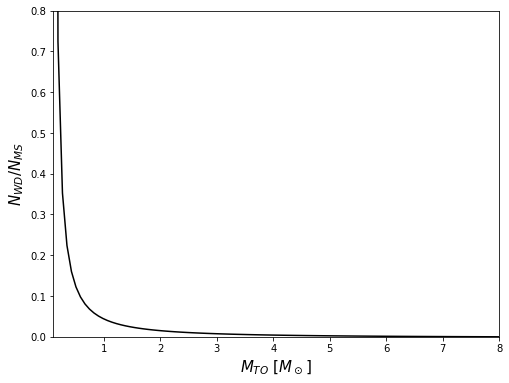

In [62]:
m1 = 0.1
mSN = 8.
mTO = np.linspace(0.11,7.99,100)

frac = (mSN**(-1.35) - mTO**(-1.35))/(mTO**(-1.35) - m1**(-1.35))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(mTO, frac, 'k-')
ax.set_xlabel(r"$M_{TO}\ [M_\odot]$",fontsize=15)
ax.set_ylabel(r"$N_{WD}/N_{MS}$",fontsize=15)
ax.set_xlim(0.1,8)
ax.set_ylim(0.,0.8)
plt.show()